# 1. Introduction

**CREDIT CARD TRANSACTIONS FRAUD DETECTION**

**Context**
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.



**Data set link**:  https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

**ABOUT DATASET:**
- Anonymized customer data with over 284807 rows and 31 features and consists of class imbalance. 
- Transactions made by credit cards in September 2013 by European cardholders.
- Transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 
- Numerical input variables which are the result of a PCA transformation.
- This would make the dataset suitable for advanced modelling techniques including Logistic Regression, Random Forest, Xgboost and other statistical models.

The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. This would make the dataset suitable for advanced modelling techniques including LightGBM, CatBoost, and other statistical models.

Features:
    - V1-V28: Neumerical features resulted from PCA transformation with fraud being extremely rare.

    - Time: Elapsed time in seconds since the first recorded transaction.

    - Amount: Transaction amount in Euros

    - Class: Label where 1=fraud and 0 = No fraud

APPROACH & WORKFLOW:
- Exploratory Data Analysis
- Class imbalance handling with sampling techniques
- Normalization



# 2. Importing libraries

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/creditcardfraud/creditcard.csv
/kaggle/input/creditcard/creditcard.csv


In [2]:
#Importing required libraries and reading the data set
import numpy as np
import pandas as pd
from collections import Counter
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from collections import Counter
warnings.filterwarnings("ignore")

# 3. User Defined functions

### 3.1 : Inspecting data details for a dataframe

In [3]:
# Information of variables for data set:

def inspect_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Inspect the structure and quality of a pandas DataFrame.

    This function computes and returns various metadata statistics about the input DataFrame,
    including data types, missing values, blank values, unique values, and the levels of categorical features.

    Parameters:
    ----------
    data : pd.DataFrame
        The input DataFrame to inspect.

    Returns:
    -------
    pd.DataFrame
        A DataFrame summarizing:
        - Data types of each column
        - Count of blank values (' ')
        - Count and percentage of missing (NaN) values
        - Number of unique values
        - Unique levels/values per column
    """
    data_details = pd.DataFrame({
        "Data Type": data.dtypes,
        "Count of Blank Values": data.apply(lambda x: x.isin([' ']).sum(), axis=0),
        "Count of Missing Values": data.isnull().sum(),
        "% of Missing Values": round(data.isnull().sum() / len(data.index) * 100, 2),
        "No of Unique Data": data.nunique(),
        "Levels": data.apply(lambda x: str(x.unique()), axis=0)
    })

    return data_details


### 3.2 : Generating custom boxplots for multiple columns

In [4]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    """
    Generate horizontal boxplots for specified columns in a dataset.

    Parameters
    ----------
    dataset : pandas.DataFrame
        The DataFrame containing the data.

    columns_list : list of str
        List of column names to generate boxplots for.

    rows : int
        Number of rows in the subplot grid.

    cols : int
        Number of columns in the subplot grid.

    suptitle : str
        Title for the entire figure.

    Returns
    -------
    None
        Displays the boxplots.
    """
    total_plots = rows * cols
    num_columns = len(columns_list)

    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16, 25))
    fig.suptitle(suptitle, y=1.02, fontsize=25)

    axs = axs.flatten()

    for i, column in enumerate(columns_list):
        sns.boxplot(data=dataset[column], orient='h', ax=axs[i])
        skewness = round(dataset[column].skew(skipna=True), 2)
        axs[i].set_title(f"{column}, skewness: {skewness}", fontsize=12)

    # Turn off any unused subplots
    if total_plots > num_columns:
        for j in range(num_columns, total_plots):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


### 3.3 : Obtaining IQR values

In [5]:
def iqr_method(df, n, features):
    """
    Identify observations with more than 'n' outliers using the IQR method.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing numerical features.
    n : int
        Threshold count of outlier conditions a row must satisfy.
    features : list of str
        List of feature column names to evaluate.

    Returns
    -------
    list
        Indices of rows considered as outliers in more than 'n' features.
    """
    outlier_list = []

    for column in features:
        q1 = np.percentile(df[column], 25)
        q3 = np.percentile(df[column], 75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr

        # Find outlier indices for this column
        outliers_col = df[
            (df[column] < q1 - outlier_step) | (df[column] > q3 + outlier_step)
        ].index

        outlier_list.extend(outliers_col)

        # Optional: Count and print outliers per column
        out_below = df[df[column] < q1 - outlier_step]
        out_above = df[df[column] > q3 + outlier_step]
        print(f"{column} → Outliers below: {out_below.shape[0]}, above: {out_above.shape[0]}")

    # Get rows that are outliers in more than 'n' features
    outlier_counts = Counter(outlier_list)
    multiple_outliers = [k for k, v in outlier_counts.items() if v > n]

    print(f"Total number of multi-feature outliers: {len(multiple_outliers)}")
    return multiple_outliers


### 3.4 : Identifying column type from entire dataset

In [6]:
def col_type(df):
    """
    Identify categorical and numerical columns in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The input dataframe to analyze.

    Returns
    -------
    tuple
        A tuple containing:
        - cat_cols: Categorical columns (dtype == 'object')
        - num_cols: Numerical columns (all others)
    """
    category = 'object'
    cat_cols = df.select_dtypes(include=category).columns
    num_cols = df.select_dtypes(exclude=category).columns
    return cat_cols, num_cols



### 3.5: Generating histplot for numerical variables and 1 target numerical variable for entire dataframe

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def numcol_plot(df, target):
    """
    Generate 2D histogram (heatmap) plots for all numerical columns against a target variable.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing numeric and target columns.
    target : str
        Name of the target column to compare against.
    """
    _, num_cols = col_type(df)
    colrefs = list(df[num_cols].columns)

    # Remove the target column and assumed ID/index column
    if target in colrefs:
        colrefs.remove(target)
    colrefs = colrefs[1:]

    for col in colrefs:
        plt.figure(figsize=(8, 6))
        sns.histplot(
            data=df,
            x=col,
            y=target,
            bins=50,
            pmax=0.95,
            cmap='viridis'
        )
        plt.title(f"{col} vs {target} (2D Histogram)", fontsize=12, fontweight='bold')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.tight_layout()
        plt.show()


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def boxplot_by_class(df, variables=None, class_col='Class'):
    """
    Create subplots of boxplots for numeric features split by class.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    variables : list of str
        List of numeric columns to include. Defaults to V1–V28 if None.
    class_col : str
        Categorical column to group by (default is 'Class').
    """
    if variables is None:
        variables = [f"V{i}" for i in range(1, 29)]

    num_vars = len(variables)
    n_cols = 4
    n_rows = int(np.ceil(num_vars / n_cols))

    plt.figure(figsize=(4 * n_cols, 3.5 * n_rows))

    for i, var in enumerate(variables, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=class_col, y=var, data=df, showfliers=False, palette='Set2')
        plt.title(f"{var} by Class", fontsize=10)
        plt.xlabel('')
        plt.ylabel('')
        plt.tight_layout()

    plt.suptitle("Boxplots of V1–V28 by Fraud Class", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# 4. Reading and Understanding the data

Data Understanding:
- Read the data from the csv file
- Find the dimensions pf the read data

In [11]:
#Read the data set from file
fraud_cc_df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv', sep=',')

#Get dimentions
print("Data dimensions:",fraud_cc_df.shape)


Data dimensions: (284807, 31)


In [12]:
# Data set summary with size of rows, columns, data types, non null values
fraud_cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

1. All the columns are in float format as expected due to PCA of all the variables.
2. The dataset has 284,807 rows (transactions) and 31 columns (features).

3. Of the 31 columns:

   - 30 columns are numerical (float64) features.

   - 1 column (Class) is categorical (int64), indicating the target (fraud or not).



# 5. Exploratory Data Analysis

EDA:
- Finding the summary of the data

EDA:
- Principle Component Analysis performed on the data set.
    - Convert large data set to possibly correlated data with smaller set of uncorrelated variables by retaining the original data's variability.
- PCA features analysis for distribution shape, plot for fraud and non-fraud class, correlation heatmap and feature importance.




## 5.1 Understanding the data summary, unique and null values

In [13]:
#Describe the data , You can see the count, mean, std, min, max, 25%, etc
fraud_cc_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.369007e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.021879e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.500885e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.620335e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.149614e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.426963e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [13]:
fraud_summary_df = inspect_data(fraud_cc_df)

fraud_summary_df.head(100)

,Data Type,Count of Blank Values,Count of Missing Values,% of Missing Values,No of Unique Data,Levels
Time,float64,0,0,0.0,124592,[0.00000e+00 1.00000e+00 2.00000e+00 ... 1.727...
V1,float64,0,0,0.0,275663,[-1.35980713 1.19185711 -1.35835406 ... 1.91...
V2,float64,0,0,0.0,275663,[-0.07278117 0.26615071 -1.34016307 ... -0.30...
V3,float64,0,0,0.0,275663,[ 2.53634674 0.16648011 1.77320934 ... -3.24...
V4,float64,0,0,0.0,275663,[ 1.37815522 0.44815408 0.37977959 ... -0.55...
V5,float64,0,0,0.0,275663,[-0.33832077 0.06001765 -0.50319813 ... 2.63...
V6,float64,0,0,0.0,275663,[ 0.46238778 -0.08236081 1.80049938 ... 3.03...
V7,float64,0,0,0.0,275663,[ 0.23959855 -0.07880298 0.79146096 ... -0.29...
V8,float64,0,0,0.0,275663,[ 0.0986979 0.08510165 0.24767579 ... 0.70...
V9,float64,0,0,0.0,275663,[ 0.36378697 -0.25542513 -1.51465432 ... 0.43...


**Dataset Structure**
- The dataset contains 284,807 records (rows) and 30 columns (features), where:

- Time, Amount, V1–V28 are feature variables.

- Class is the target variable, likely indicating fraud (1) vs non-fraud (0).

**Data Quality Check**
- No missing or blank values in any feature — the dataset is clean and ready for modeling.

- All variables are numerical (float64 or int64), so no encoding is required.

- This allows seamless use of machine learning models without additional preprocessing for nulls or data types.

**Time Feature**
- Represents elapsed time from the first transaction in seconds.

- Ranges from 0 to ~172,792 seconds (~48 hours).

- Median time is ~84,692 seconds, indicating a fairly even spread of transactions over two days.

**PCA-like Features (V1 to V28)**
- These features:

   - Have mean ≈ 0 and standard deviation ≈ 1, confirming they are likely PCA-transformed (standardized) values — typical in privacy-preserving datasets like credit card fraud detection.

  - Have high cardinality (around 275,000 unique values), indicating they are continuous.

  - Exhibit heavy tails and possible outliers (e.g., V5 min = -113.74, V20 min = -54.49), which can affect model performance.

**Amount Feature**
- Represents transaction value:

  - Mean = ₹88.35, Median = ₹22.00, Max = ₹25,691.16.

  - The large spread and skew (75th percentile = ₹77.17) indicate significant outliers and long-tail distribution.

  - Standardization or log-transformation may help stabilize variance.

**Target Variable: Class**
- Binary variable:

  - 0 = Non-fraud, 1 = Fraud.

  - Only 0.17% (≈492 cases) are frauds.

- Severe class imbalance:

  - Needs resampling (e.g., SMOTE, ADASYN), cost-sensitive models, or anomaly detection methods.

- Evaluation should focus on recall, precision, F1-score, and ROC-AUC, not accuracy. - In this case will focus on AUC values.

**Feature Distribution and Skew**
- Some features (V5, V20, V27, V28) show very large ranges, suggesting outliers.

- Others have more symmetric distributions (V13, V24, etc.).

- Visualization with boxplots or histograms can help decide transformation or outlier handling.

- All feature columns except Class are continuous numerical variables (float64), while Class is a binary categorical variable (int64), which typically represents the target in classification tasks.

- The Time and Amount fields have distinct characteristics:

- Time has 124,592 unique values, likely representing transaction timestamps.

- Amount has 32,767 unique values, suggesting continuous variation in transaction amounts.

- Columns V1 to V28 are likely anonymized or PCA-transformed components (common in fraud detection datasets like the Credit Card Fraud Detection dataset). Each of these has a high number of unique values (~275,663), indicating they are high-cardinality continuous features.

- The Class column has 2 unique values: [0, 1], representing two classes (e.g., legitimate vs fraudulent transactions).
**Implications for Modeling**
- The dataset is:

  - Pre-processed (no nulls, standardized PCA components).

  - High-dimensional but numerical, suitable for models like:

  - Logistic Regression (with class weighting),

  - Random Forest, XGBoost (with early stopping & scale_pos_weight),

  - Requires careful cross-validation with stratification due to the imbalance.

**Summary:**
- Handle class imbalance through upsampling or penalized models.

- Consider transforming Amount to reduce skew.

- Use precision-recall metrics for model evaluation.

- Visualize key features to detect outliers or multimodal distributions.

- No missing data or categorical features — saves significant preprocessing time.

## 5.2 Univariate analysis visualizations

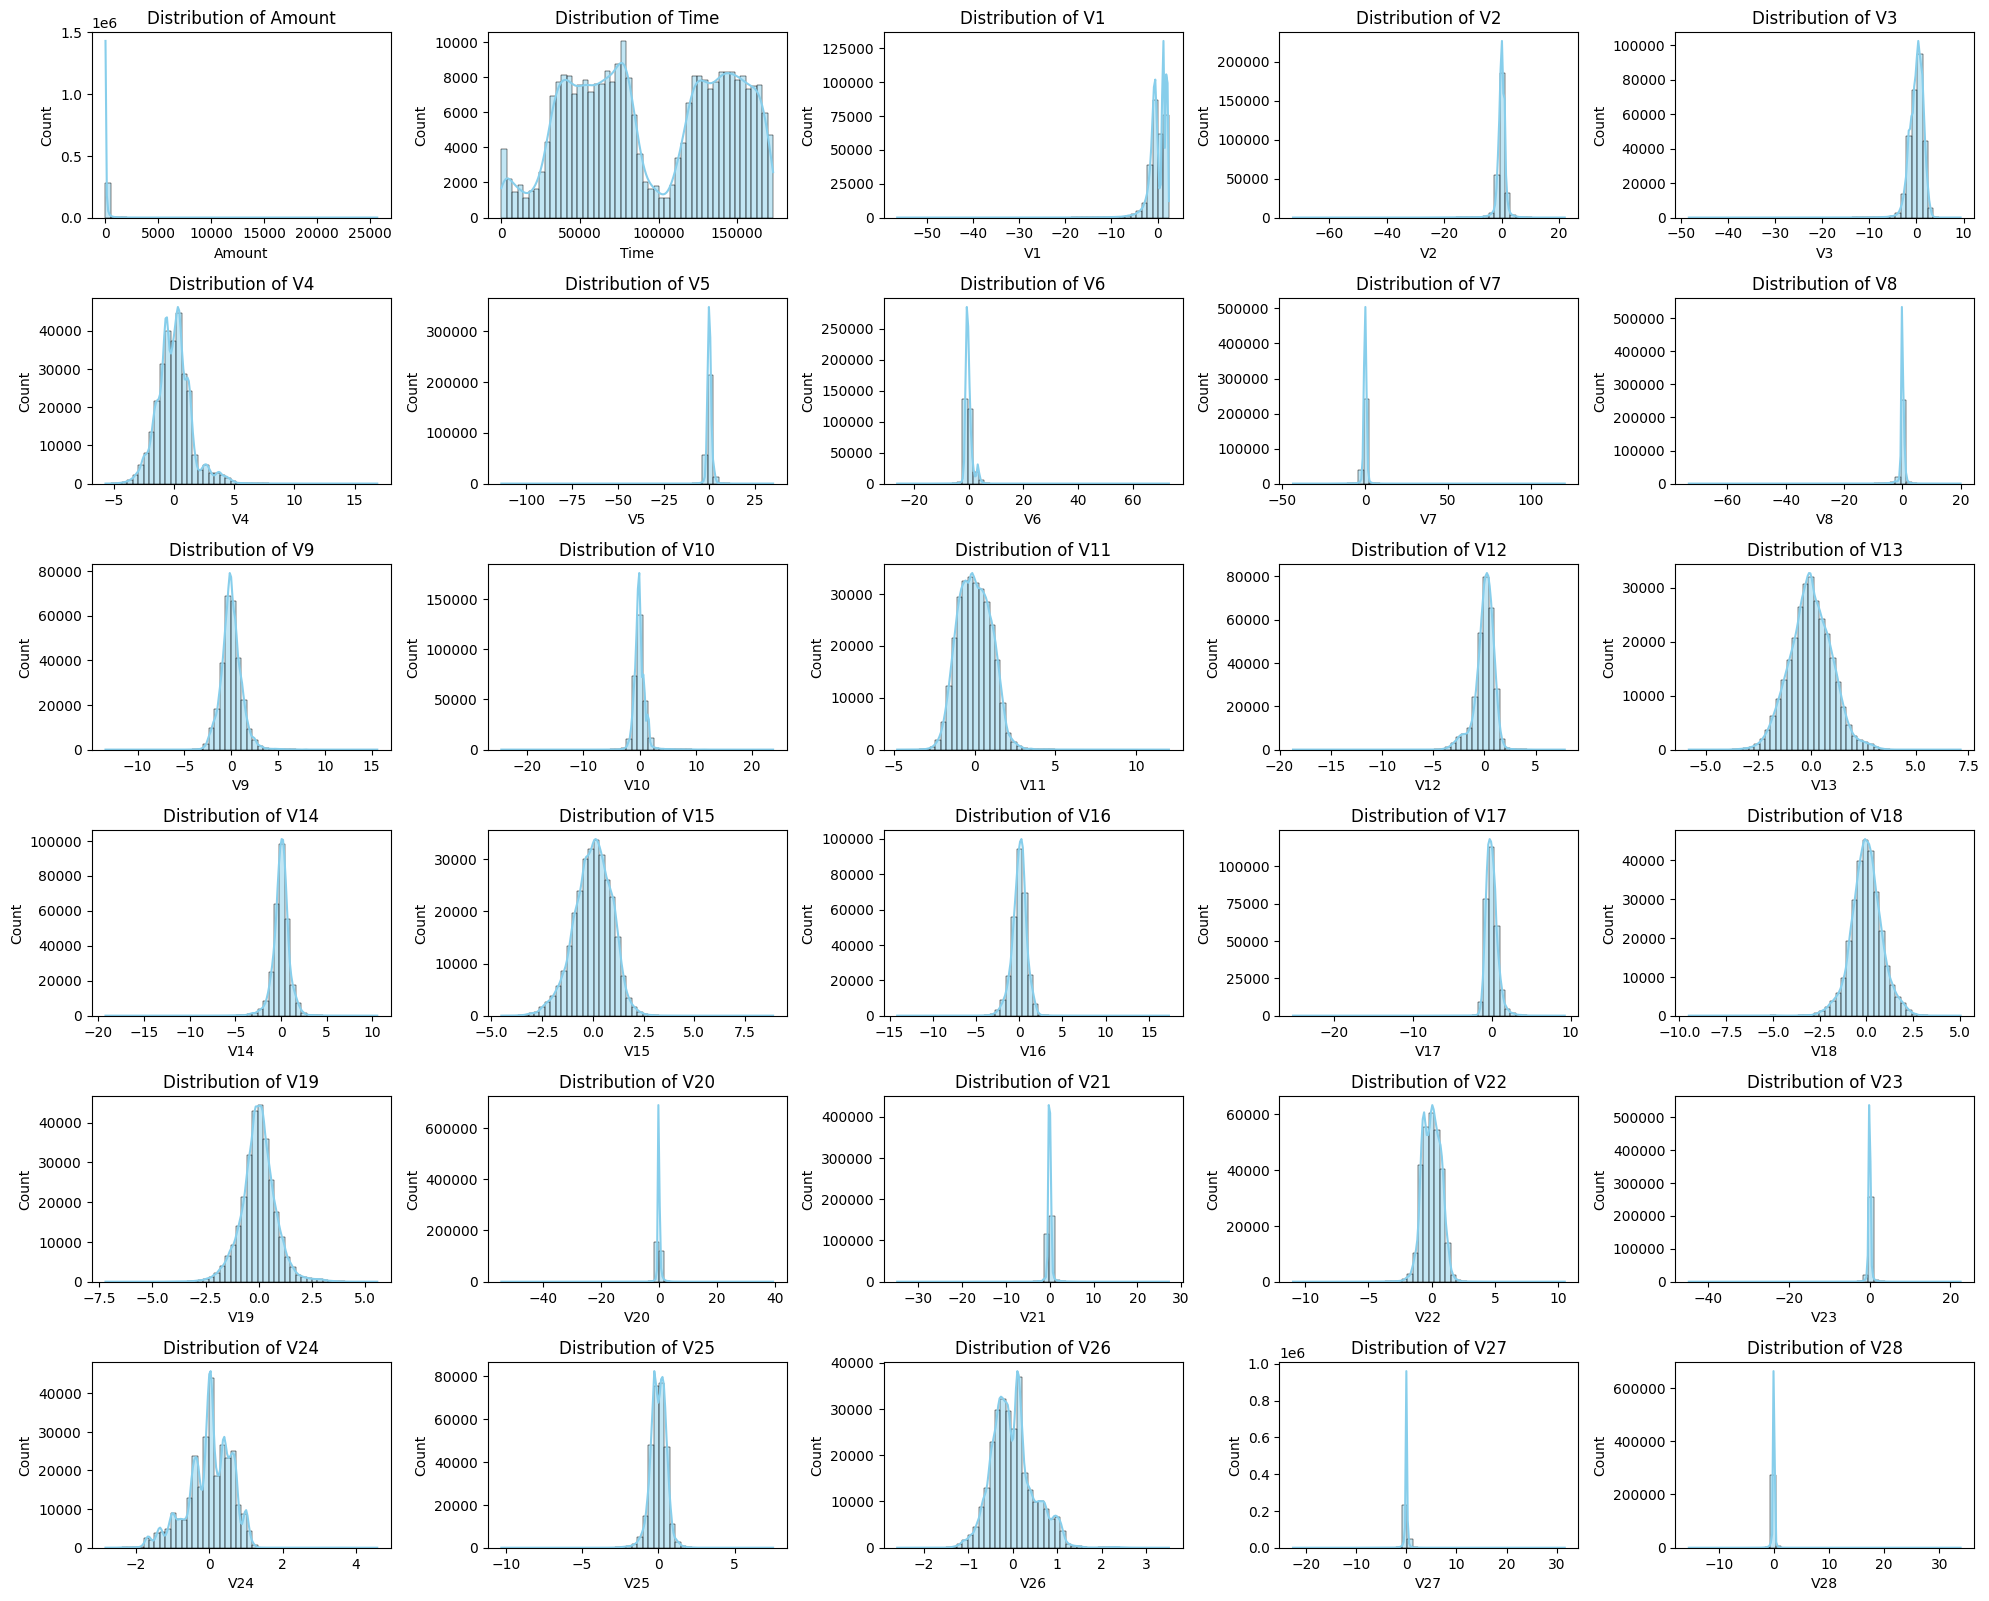

In [15]:
# Select a subset of features for univariate analysis
features_to_plot = ['Amount', 'Time'] + [f'V{i}' for i in range(1, 29)] 

# Set up the plot grid
num_features = len(features_to_plot)
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20, 21))
axes = axes.flatten()

# Plot distribution for each feature
for i, feature in enumerate(features_to_plot):
    sns.histplot(fraud_cc_df[feature], bins=50, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)

# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final layout adjustment and save
plt.tight_layout()
#plt.savefig('univariate_analysis_plots.png')

plt.show()


**SUMMARY:**
- Most likely usefull: V4, V10, V12, V14, V17
- Low variance: V20, V21, V25, V2
- May benefit from transformation: V2, V10, V14, V23

| Feature |         Shape             | Outliers |      Interpretation                        |
| ------- | ------------------------- | --------- | ----------------------------------------- |
| **V1**  | Bell-shaped, slight tails | Minor     | Stable distribution, moderate variance    |
| **V2**  | Skewed left, heavy tails  | Yes       | Could capture abnormal activity           |
| **V3**  | Bell with fat tails       | Yes       | Likely useful for modeling                |
| **V4**  | Long tail, asymmetric     | Yes       | Known fraud-separating feature            |
| **V5**  | Normal-ish                | Few       | May contribute to combined signal         |
| **V6**  | Centered, asymmetric      | Yes       | Moderate variance                         |
| **V7**  | Near-flat, wide range     | Few       | Lower density; may be weak alone          |
| **V8**  | Symmetric, low peak       | No        | Likely low information feature            |
| **V9**  | Tailed distribution       | Yes       | High range; potential fraud marker        |
| **V10** | Strong left skew          | Yes       | **Important feature in fraud detection**  |
| **V11** | Sharp peak, narrow        | No        | Limited discriminative power              |
| **V12** | Strong skew               | Yes       | Sensitive to rare patterns                |
| **V13** | Slight asymmetry          | Few       | Could be mid-strength                     |
| **V14** | Highly skewed             | Yes       | One of the **top fraud indicators**       |
| **V15** | Symmetric, narrow         | No        | Low signal visually                       |
| **V16** | Symmetric, flat peak      | No        | Weak on its own                           |
| **V17** | Asymmetric, wide          | Yes       | Often useful with interactions            |
| **V18** | Low variance              | No        | Low standalone value                      |
| **V19** | Flat distribution         | No        | Could be ignored                          |
| **V20** | Near-constant             | No        | Minimal variance — likely non-informative |
| **V21** | Similar to V20            | No        | Same — likely low impact                  |
| **V22** | Asymmetric, light tail    | Few       | May show rare events                      |
| **V23** | Long-tailed               | Yes       | Could relate to fraud dynamics            |
| **V24** | Bell with outliers        | Yes       | Moderate potential                        |
| **V25** | Flat, low spread          | No        | Weak predictor alone                      |
| **V26** | Some outliers             | Yes       | Worth modeling with others                |
| **V27** | Very tight range          | No        | Potential candidate to drop               |
| **V28** | Symmetric, clean          | No        | Good baseline input                       |



**Further steps:** 
- V2, V10, V14 and V23 features shows strong skew and lengthy tails. This can affect the accuracy of the model.
- These are improved by scaling.
- Robustscaler(): Scales using median and IQR(Interquile range).
- Xscaled = X-Mean/IQR

## 5.3: Class Imbalance check

In [16]:
# labels=["Genuine","Fraud"]

# fraud_or_not = fraud_cc_df["Class"].value_counts().tolist()
# values = [fraud_or_not[0], fraud_or_not[1]]

# fig = px.pie(values=fraud_cc_df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
#              ,title="Fraud vs Genuine transactions")
# fig.show()

vc = fraud_cc_df['Class'].value_counts().sort_index()
labels = ["Genuine", "Fraud"]
fig = px.pie(
    values=vc,
    names=labels,
    title="Fraud vs Genuine Transactions",
    color_discrete_sequence=["skyblue", "black"],
    width=700,
    height=400
)
fig.show()


**Interpretation**
- The dataset is extremely imbalanced, with fraudulent transactions (Class 1) making up only 0.17% of the total transactions.

- This means for every 1 fraud, there are approximately 578 genuine transactions.

- The imbalance presents a significant challenge for machine learning models because:

- Most models will be biased toward predicting the majority class (Genuine).

- Metrics like accuracy will be misleading — a model predicting all transactions as "Genuine" will still appear 99.83% accurate.

**Implication: Use specialized techniques to address class imbalance:**

- Resampling: e.g., SMOTE (oversampling), undersampling.

- Class-weight adjustment: in models like Logistic Regression, Random Forest, XGBoost.

- Evaluation metrics: use F1-score, AUC-ROC instead

## 5.4 : Checking for any data duplicity

In [14]:
fraud_cc_df_dedup = fraud_cc_df.copy()

fraud_cc_df_dedup.drop_duplicates(inplace=True)
print("Original #of records:", fraud_cc_df.shape[0],
     "after drop duplicates- #of records:", fraud_cc_df_dedup.shape[0],"\n",
fraud_cc_df.shape[0]-fraud_cc_df_dedup.shape[0],
    "Duplicated values dropped succesfully")
print("*" * 100)

Original #of records: 284807 after drop duplicates- #of records: 283726 
 1081 Duplicated values dropped succesfully
****************************************************************************************************


- ~0.4% data is duplicated and it is removed from this dataset

## 5.5:   Why we shouldn't delete outliers in this case¶


### Checking for outliers

In [15]:
numeric_columns = (list(fraud_cc_df_dedup.loc[:, 'V1':'Amount']))

numeric_columns

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [ ]:
# checking boxplots
# def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
#     fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
#     fig.suptitle(suptitle,y=1, size=25)
#     axs = axs.flatten()
#     for i, data in enumerate(columns_list):
#         sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
#         axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
# boxplots_custom(dataset=fraud_cc_df_dedup, columns_list=numeric_columns, rows=10, cols=3, suptitle='Boxplots for each variable')
# plt.tight_layout()

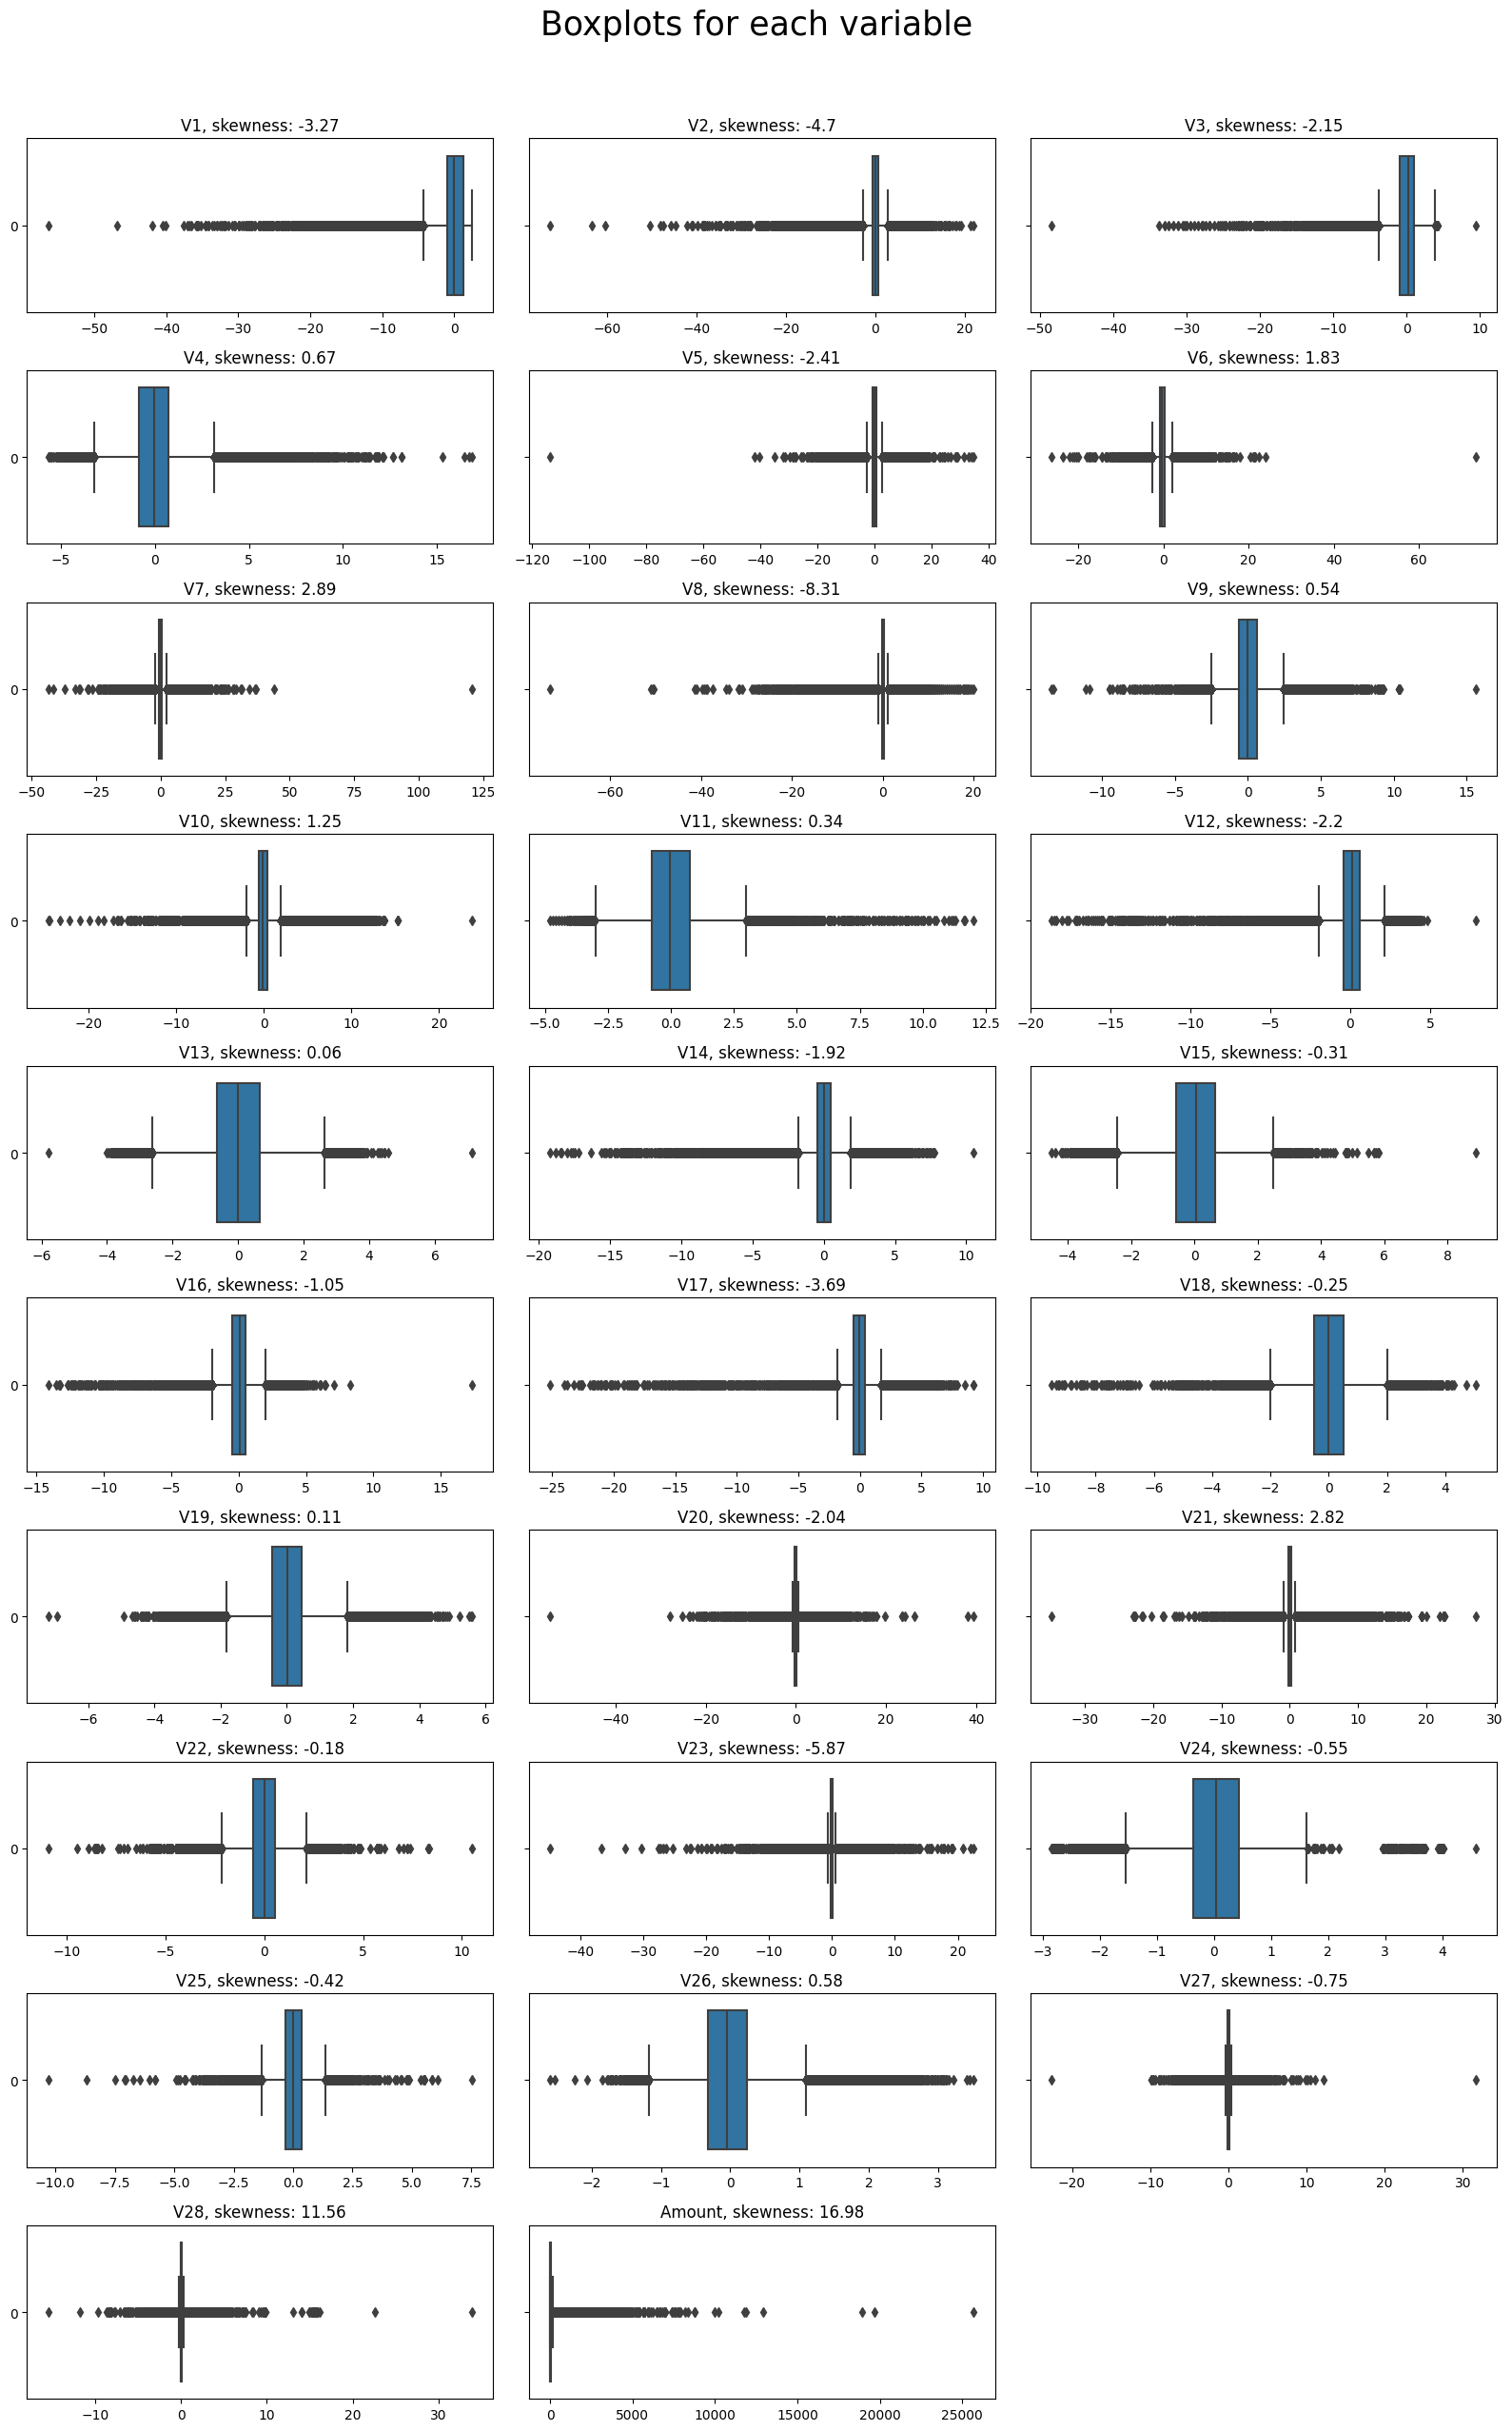

<Figure size 640x480 with 0 Axes>

In [19]:
boxplots_custom(dataset=fraud_cc_df_dedup, columns_list=numeric_columns, rows=10, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

**General Observations from Boxplots**

1. **Outliers**  
   - Most features show visible outliers beyond the whiskers — especially `V2`, `V3`, `V4`, `V10`, `V12`, `V14`, and `Amount`.  
   - These may represent rare behaviors, potentially indicative of fraudulent activity.

2. **Skewed Distributions**
   - **Highly right-skewed**:  
     `V1`, `V6`, `V9`, `V10`, `V12`, `V14`, `V20`, `V21`, `V22`, `V24`, `V25`, `Amount`
   - **Highly left-skewed**:  
     `V2`, `V3`, `V5`
   - **Approximately symmetric**:  
     `V11`, `V13`, `V15`, `V16`, `V28`  
   - Features with skewness > |2| are highly asymmetric and likely require transformation (e.g., log, Box-Cox).

3. **Low Variance / Near-Constant Features**
   - Features like `V27`, `V26`, `V20`, `V21` have tight boxplots and very short whiskers.
   - These may contribute little signal and should be evaluated for removal or dimensionality reduction.

4. **Notable Feature-Level Insights**
   - `V2` (Skewness: -4.7): Strong left skew with outliers — may capture anomalies.
   - `V3`, `V10`, `V12`, `V14`, `V17`, `V18`: Long-tailed and skewed — potentially informative for fraud detection.
   - `Amount` (Skewness: 16.98): Extremely right-skewed due to high-value transactions. Consider applying log transformation to normalize.

---


### IQR and Outlier

**Inter Quartile Range (IQR)**
- We have a significant problems with outliers:

- huge outliers;

- higly skeved data;

- a lot of outliers.

- Tukey’s (1977) technique is used to detect outliers in skewed or non bell-shaped data since it makes no distributional assumptions. However, Tukey’s method may not be appropriate for a small sample size. The general rule is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed.

- Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal.

- Procedure:

  - Find the first quartile, Q1.
  - Find the third quartile, Q3.
  - Calculate the IQR. IQR = Q3-Q1.
  - Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.

In [20]:
# def IQR_method (df,n,features):
#     """
#     Takes a dataframe and returns an index list corresponding to the observations 
#     containing more than n outliers according to the Tukey IQR method.
#     """
#     outlier_list = []
    
#     for column in features:
#         # 1st quartile (25%)
#         Q1 = np.percentile(df[column], 25)
#         # 3rd quartile (75%)
#         Q3 = np.percentile(df[column],75)
#         # Interquartile range (IQR)
#         IQR = Q3 - Q1
#         # outlier step
#         outlier_step = 1.5 * IQR
#         # Determining a list of indices of outliers
#         outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
#         # appending the list of outliers 
#         outlier_list.extend(outlier_list_column)
        
#     # selecting observations containing more than x outliers
#     outlier_list = Counter(outlier_list)        
#     multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
#     # Calculate the number of records below and above lower and above bound value respectively
#     out1 = fraud_cc_df_dedup[fraud_cc_df_dedup[column] < Q1 - outlier_step]
#     out2 = fraud_cc_df_dedup[fraud_cc_df_dedup[column] > Q3 + outlier_step]
    
#     print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
#     return multiple_outliers


In [21]:
# detecting outliers
Outliers_IQR = iqr_method(fraud_cc_df_dedup,1,numeric_columns)
print(len(Outliers_IQR))

V1 → Outliers below: 6948, above: 0
V2 → Outliers below: 8418, above: 4972
V3 → Outliers below: 3286, above: 20
V4 → Outliers below: 2245, above: 8849
V5 → Outliers below: 3821, above: 8400
V6 → Outliers below: 1744, above: 21142
V7 → Outliers below: 4740, above: 4099
V8 → Outliers below: 12191, above: 11713
V9 → Outliers below: 2409, above: 5790
V10 → Outliers below: 3344, above: 6001
V11 → Outliers below: 114, above: 621
V12 → Outliers below: 14546, above: 736
V13 → Outliers below: 1142, above: 2220
V14 → Outliers below: 8707, above: 5353
V15 → Outliers below: 2462, above: 422
V16 → Outliers below: 6514, above: 1666
V17 → Outliers below: 715, above: 6638
V18 → Outliers below: 3944, above: 3524
V19 → Outliers below: 5045, above: 5105
V20 → Outliers below: 8589, above: 18964
V21 → Outliers below: 6389, above: 8012
V22 → Outliers below: 913, above: 385
V23 → Outliers below: 8138, above: 10329
V24 → Outliers below: 4622, above: 136
V25 → Outliers below: 3666, above: 1667
V26 → Outliers b

**What the Output Means**
- 81014 rows in your dataset are considered outliers in more than 1 feature (i.e., they violate the IQR threshold in at least two features).

- These are considered potential multivariate outliers, which might indicate anomalous or extreme patterns across multiple variables — not just one.

- This is especially relevant in fraud detection, as fraudulent transactions may exhibit outlier behavior across multiple numeric dimensions simultaneously (e.g., unusually high amount, uncommon time, etc.).

## 5.6 : Class imbalance check post dedupe

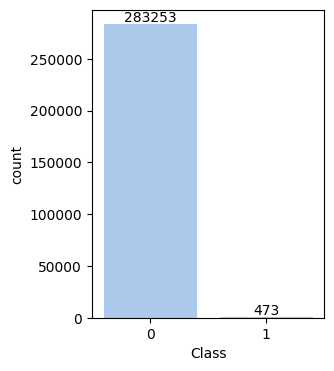

In [22]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=fraud_cc_df_dedup,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)



Fraud Rate:
Total counts=283726
Non Fraud (Class:0) counts=283253
Fraud (Class:1) counts=473
Non Fraud = 99.83 %
Fraud = 0.17 %

Observations:
The Class data is highly imbalanced. Non Fraud counts are greater than Fraud counts.
Due to highly imbalanced data, resampling techniques are required

Average, there is 1 fraud cases per 599 transactions.


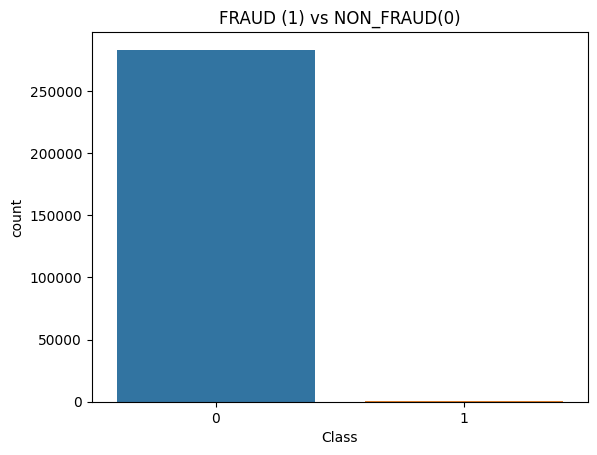

In [23]:
sns.countplot(data=fraud_cc_df_dedup, x='Class')
FraudRate= fraud_cc_df_dedup['Class'].value_counts(normalize=True)*100
print("Fraud Rate:")

counts=fraud_cc_df_dedup['Class'].value_counts()
totalcount=counts[0]+counts[1]
Frd_cnt=totalcount/counts[1]

print(f"Total counts={totalcount}")
print(f"Non Fraud (Class:0) counts={counts[0]}")
print(f"Fraud (Class:1) counts={counts[1]}")
print(f"Non Fraud = {FraudRate[0]:.2f} %")
print(f"Fraud = {FraudRate[1]:.2f} %")
print("\nObservations:")
print("The Class data is highly imbalanced. Non Fraud counts are greater than Fraud counts.")
print("Due to highly imbalanced data, resampling techniques are required")
print(f"\nAverage, there is 1 fraud cases per 599 transactions.")
plt.title("FRAUD (1) vs NON_FRAUD(0)")
plt.show()

- Dataset is highly imbalanced:
- Only 473 out of 283,726 transactions (~0.17%) are fraudulent.

- This class imbalance is typical in real-world fraud detection problems — fraud is rare but costly.

## 5.7: Bivariate analysis

 **Bivariate analysis:**
 - Relationship between two variables. Features vs class.
   1) Amount vs class.</br>
   2) Time vs class.
   3) Amount vs time


In [24]:
# # Convert time to hours
# fraud_cc_df_dedup['Hour'] = (fraud_cc_df_dedup['Time'] // 3600) % 24

# # Create a log-scaled amount for visualization
# fraud_cc_df_dedup['LogAmount'] = fraud_cc_df_dedup['Amount'].apply(lambda x: np.log1p(x))

# # 1. Boxplot: Amount vs Class (Fraud/Not Fraud)
# plt.figure(figsize=(8, 5))
# sns.boxplot(x='Class', y='Amount', data=fraud_cc_df_dedup, showfliers=False)
# plt.title("Bivariate Analysis: Transaction Amount vs Fraud")
# plt.xlabel("Class (0 = Not Fraud, 1 = Fraud)")
# plt.ylabel("Transaction Amount")
# print("                           BIVARIATE ANALYSIS TRANSACTION AMOUNT vs FRAUD             ")
# print("\nFraud transactions often have lower median values but can also include some high-value outliers.")
# print("Non-fraud transactions show a wider range.")
# plt.show()

# # 2. Boxplot: Time of day vs Class
# plt.figure(figsize=(8, 5))
# sns.boxplot(x='Class', y='Hour', data=fraud_cc_df_dedup)
# plt.title("Bivariate Analysis: Hour of Day vs Fraud")
# plt.xlabel("Class (0 = Not Fraud, 1 = Fraud)")
# plt.ylabel("Hour of Day")
# print("                           BIVARIATE ANALYSIS TRANSACTION HOUR's OF DAY vs FRAUD             ")
# print("Fraud may inrease during off-business hours like night/early morning.")
# plt.show()

# # 3. Scatter Plot: Amount vs Time (colored by Class)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Time', y='Amount', hue='Class', data=fraud_cc_df_dedup.sample(5000), alpha=0.5, palette={0: 'blue', 1: 'red'})
# plt.title("Bivariate Scatter: Time vs Amount (Color = Fraud Class)")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Amount")
# plt.legend(title="Class", labels=["Not Fraud", "Fraud"])
# print("                           BIVARIATE ANALYSIS TIME vs AMOUNT             ")
# print("Red dots (fraud) may cluster at specific time windows and amount ranges.")
# plt.show()

# print("BIVARIATE ANALYSIS PAIR PLOTs")

# sns.pairplot(fraud_cc_df_dedup[['Amount', 'Hour', 'Class']], hue='Class', diag_kind='kde')


# # Show the plot (important in scripts)
# plt.show()

📊 BIVARIATE ANALYSIS: TRANSACTION AMOUNT vs FRAUD


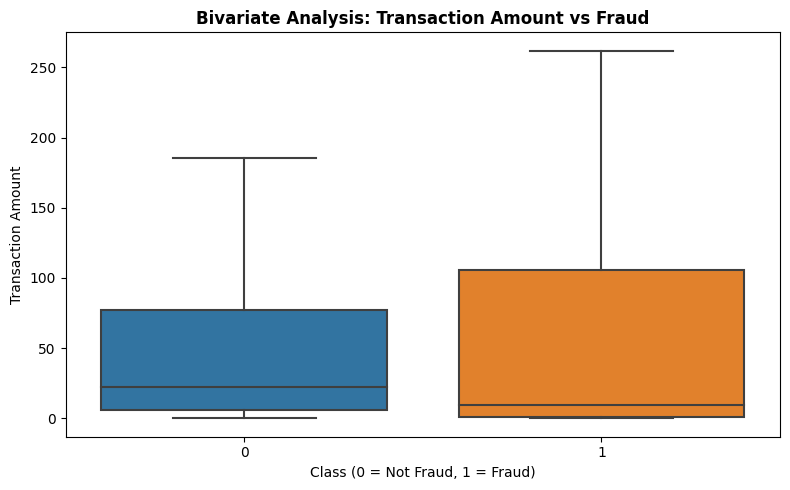

Fraud transactions often have lower median values but can also include high-value outliers.
Non-fraud transactions show a broader amount range.

📊 BIVARIATE ANALYSIS: TRANSACTION HOUR OF DAY vs FRAUD


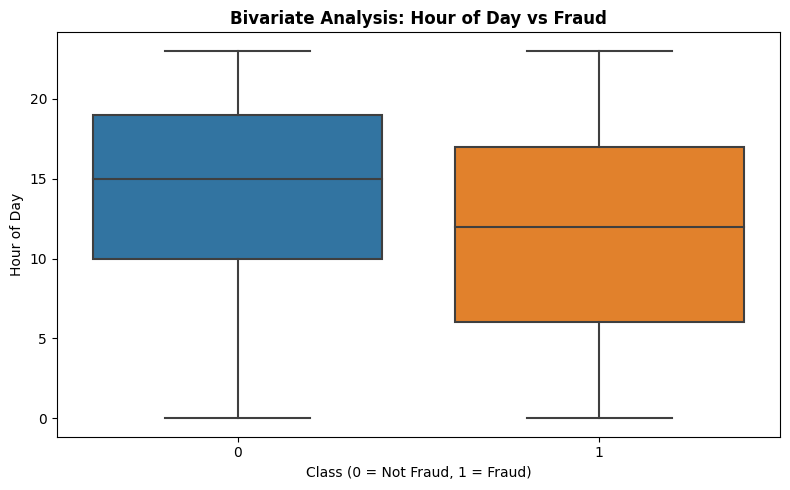

Fraud might increase during non-business hours like night/early morning.

📊 BIVARIATE ANALYSIS: TIME vs AMOUNT


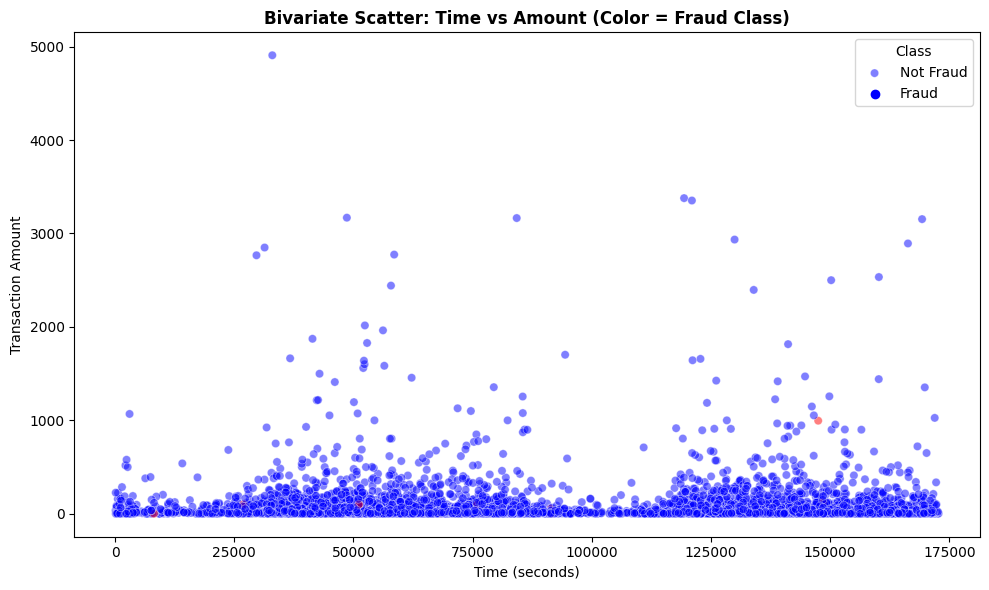

Red dots (fraud) may cluster at specific time windows or amount ranges.

📊 BIVARIATE ANALYSIS: PAIR PLOTS


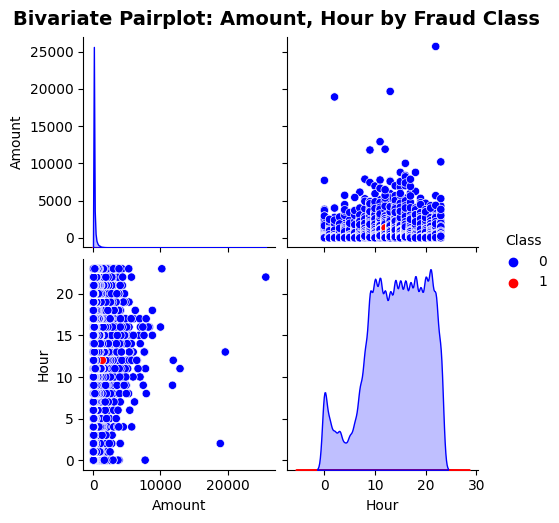

In [25]:
# Convert time to hours
fraud_cc_df_dedup['Hour'] = (fraud_cc_df_dedup['Time'] // 3600) % 24

# Create a log-scaled amount for visualization
fraud_cc_df_dedup['LogAmount'] = fraud_cc_df_dedup['Amount'].apply(lambda x: np.log1p(x))

# 1. Boxplot: Amount vs Class
print("📊 BIVARIATE ANALYSIS: TRANSACTION AMOUNT vs FRAUD")
plt.figure(figsize=(8, 5))
sns.boxplot(x='Class', y='Amount', data=fraud_cc_df_dedup, showfliers=False)
plt.title("Bivariate Analysis: Transaction Amount vs Fraud", fontsize=12, fontweight='bold')
plt.xlabel("Class (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount")
plt.tight_layout()
plt.show()
print("Fraud transactions often have lower median values but can also include high-value outliers.")
print("Non-fraud transactions show a broader amount range.\n")

# 2. Boxplot: Hour vs Class
print("📊 BIVARIATE ANALYSIS: TRANSACTION HOUR OF DAY vs FRAUD")
plt.figure(figsize=(8, 5))
sns.boxplot(x='Class', y='Hour', data=fraud_cc_df_dedup)
plt.title("Bivariate Analysis: Hour of Day vs Fraud", fontsize=12, fontweight='bold')
plt.xlabel("Class (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()
print("Fraud might increase during non-business hours like night/early morning.\n")

# 3. Scatter Plot: Time vs Amount
print("📊 BIVARIATE ANALYSIS: TIME vs AMOUNT")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Time',
    y='Amount',
    hue='Class',
    data=fraud_cc_df_dedup.sample(5000),
    alpha=0.5,
    palette={0: 'blue', 1: 'red'}
)
plt.title("Bivariate Scatter: Time vs Amount (Color = Fraud Class)", fontsize=12, fontweight='bold')
plt.xlabel("Time (seconds)")
plt.ylabel("Transaction Amount")
plt.legend(title="Class", labels=["Not Fraud", "Fraud"])
plt.tight_layout()
plt.show()
print("Red dots (fraud) may cluster at specific time windows or amount ranges.\n")

# 4. Pairplot: Amount, Hour, Class
print("📊 BIVARIATE ANALYSIS: PAIR PLOTS")
pairplot_fig = sns.pairplot(
    fraud_cc_df_dedup[['Amount', 'Hour', 'Class']],
    hue='Class',
    diag_kind='kde',
    palette={0: 'blue', 1: 'red'}
)
pairplot_fig.fig.suptitle(
    "Bivariate Pairplot: Amount, Hour by Fraud Class",
    fontsize=14, fontweight='bold', y=1.03
)
plt.show()


**Bivariate Analysis – Interpretation (Fraud Detection)

1. Boxplot – Transaction Amount vs Class

- **Class 0** represents non-fraudulent transactions, and **Class 1** represents fraud.
- Fraudulent transactions generally have a **lower median transaction amount** compared to non-fraud.
- However, some fraudulent cases exhibit **extremely high amounts**, indicating potential outliers or high-value fraud attempts.
- Non-fraudulent transactions display a **broader range of transaction values**, reflecting more diverse customer behavior.

   **Insight**: While most frauds are small (likely to avoid suspicion), high-amount frauds exist and can be especially costly.

---

 2. Boxplot – Hour of Day vs Class

- This boxplot compares the **hour of the transaction** across fraud and non-fraud cases.
- Fraud transactions are slightly more concentrated during **late-night to early-morning hours (around 0–6 AM)**.
- Non-fraud transactions are more uniformly distributed across the 24-hour cycle.

**Insight**: Fraud may occur more frequently during **off-business hours**, when monitoring is likely reduced. This temporal trend can help build fraud detection rules.

---

 3. Scatter Plot – Time (in Seconds) vs Amount (Colored by Class)

- The scatter plot shows transaction **amounts over time**, with color denoting fraud class.
- Most points are concentrated in the **low amount** region, with **a few high-value spikes**.
- Fraud cases (red dots) are **sparse** and may cluster in specific time windows.

 **Insight**: Fraudulent transactions are rare and might occur in short bursts or specific patterns. Detecting clusters over time could indicate fraud bursts or coordinated attacks.

---

4. Pair Plot – Amount, Hour vs Class

- This plot visualizes pairwise relationships between `Amount`, `Hour`, and `Class`.
- The **KDE plots** on the diagonal show:
  - `Amount`: Fraud mostly occurs at **lower values**, but has a long tail.
  - `Hour`: Fraud exhibits **non-uniform activity**, with dips and spikes around specific times.
- The scatter between `Amount` and `Hour` shows:
  - Fraud transactions **cluster at lower amounts and specific hours**.

**Insight**: Multivariate patterns (e.g., low amount + odd hour) are more informative than analyzing features in isolation. These interactions are crucial for **feature engineering and model training**.

---

**Summary**

These bivariate plots suggest:
- **Fraud tends to be small in amount and occurs more during off-hours.**
- Some **high-value frauds** exist and can be high-impact.
- Time-based and amount-based **interactions** are strong fraud indicators.
- These patterns can guide both **rule-based systems** and **ML model features**.


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.countplot(data=fraud_cc_df_dedup, x='Class')
# FraudRate= fraud_cc_df_dedup['Class'].value_counts(normalize=True)*100
# print("Fraud Rate:")

# counts=fraud_cc_df_dedup['Class'].value_counts()
# totalcount=counts[0]+counts[1]
# Frd_cnt=totalcount/counts[1]

# print(f"Total counts={totalcount}")
# print(f"Non Fraud (Class:0) counts={counts[0]}")
# print(f"Fraud (Class:1) counts={counts[1]}")
# print(f"Non Fraud = {FraudRate[0]:.2f} %")
# print(f"Fraud = {FraudRate[1]:.2f} %")
# print("\nObservations:")
# print("The Class data is highly imbalanced. Non Fraud counts are greater than Fraud counts.")
# print("Due to highly imbalanced data, resampling techniques are required")
# print(f"\nAverage, there is 1 fraud cases per 599 transactions.")
# plt.title("FRAUD (1) vs NON_FRAUD(0)")
# plt.show()


## Covered above

EDA:
- Distribution of transaction amount and time which will help to identify fraud patterns 
- Distribution helps to identify outliers

Distribution of the Transaction amount is right skewed distribution.
Most of transactions are of small amount and highest distribution density is between 0 and 100


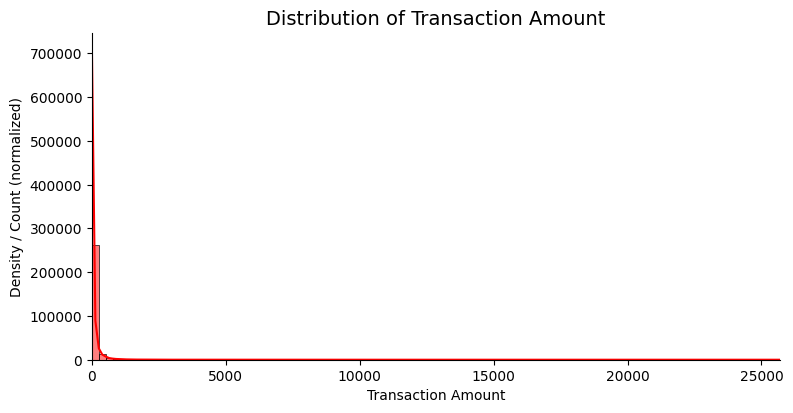

Distribution of the transaction time is unevenly distributed over the time.
More repeated transactions over specific time


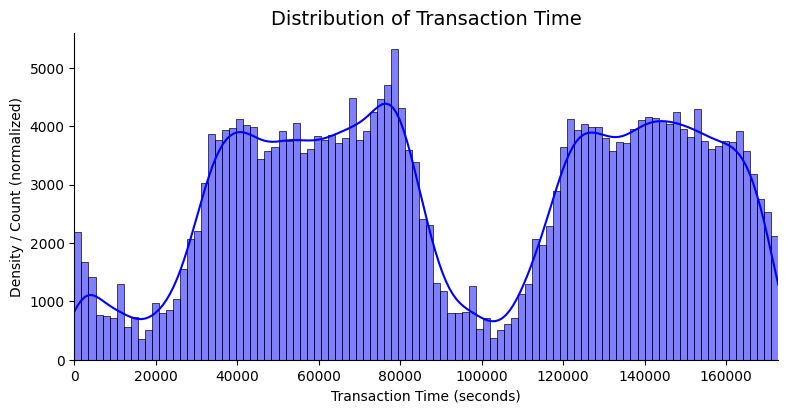

In [26]:
# Distribution of Transaction Amount
sns.displot(fraud_cc_df_dedup, x='Amount', kind='hist', bins=100, kde=True, color='r', height=4, aspect=2)
plt.title('Distribution of Transaction Amount', fontsize=14)
plt.xlim(fraud_cc_df_dedup['Amount'].min(), fraud_cc_df_dedup['Amount'].max())
plt.xlabel("Transaction Amount")
plt.ylabel("Density / Count (normalized)")
print("Distribution of the Transaction amount is right skewed distribution.")
print("Most of transactions are of small amount and highest distribution density is between 0 and 100")
plt.show()

# Distribution of Transaction Time
sns.displot(fraud_cc_df_dedup, x='Time', kind='hist', bins=100, kde=True, color='b', height=4, aspect=2)
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlim(fraud_cc_df_dedup['Time'].min(), fraud_cc_df_dedup['Time'].max())
plt.xlabel("Transaction Time (seconds)")
plt.ylabel("Density / Count (normalized)")
print("Distribution of the transaction time is unevenly distributed over the time.")
print("More repeated transactions over specific time")
plt.show()

1.  Distribution of Transaction Amount
- The distribution is **heavily right-skewed**, with most transactions concentrated under ₹500.
- Only a small fraction of transactions are high-value (₹10,000+), indicating **long-tail behavior**.
- This pattern is typical in real-world data where low-value purchases are more frequent.
- **Outlier detection** should focus on both **unusually small** and **very large transactions**, as both may indicate fraud.

2.  Distribution of Transaction Time (in seconds)
- Transaction time shows a **cyclical pattern**, not a uniform distribution.
- Peaks and dips in the density curve suggest **specific high-activity and low-activity windows**.
- These temporal patterns reflect **real-world customer behavior cycles** (like office hours or payment windows).
- In fraud analysis, **irregular activity** during **low-frequency time bands** can be a **strong indicator** of suspicious behavior.


### Bivariate plot of PCA variable vs class

In [27]:
#Finding numeric and categorical column details
col_type(fraud_cc_df_dedup)

(Index([], dtype='object'),
 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
        'Class', 'Hour', 'LogAmount'],
       dtype='object'))

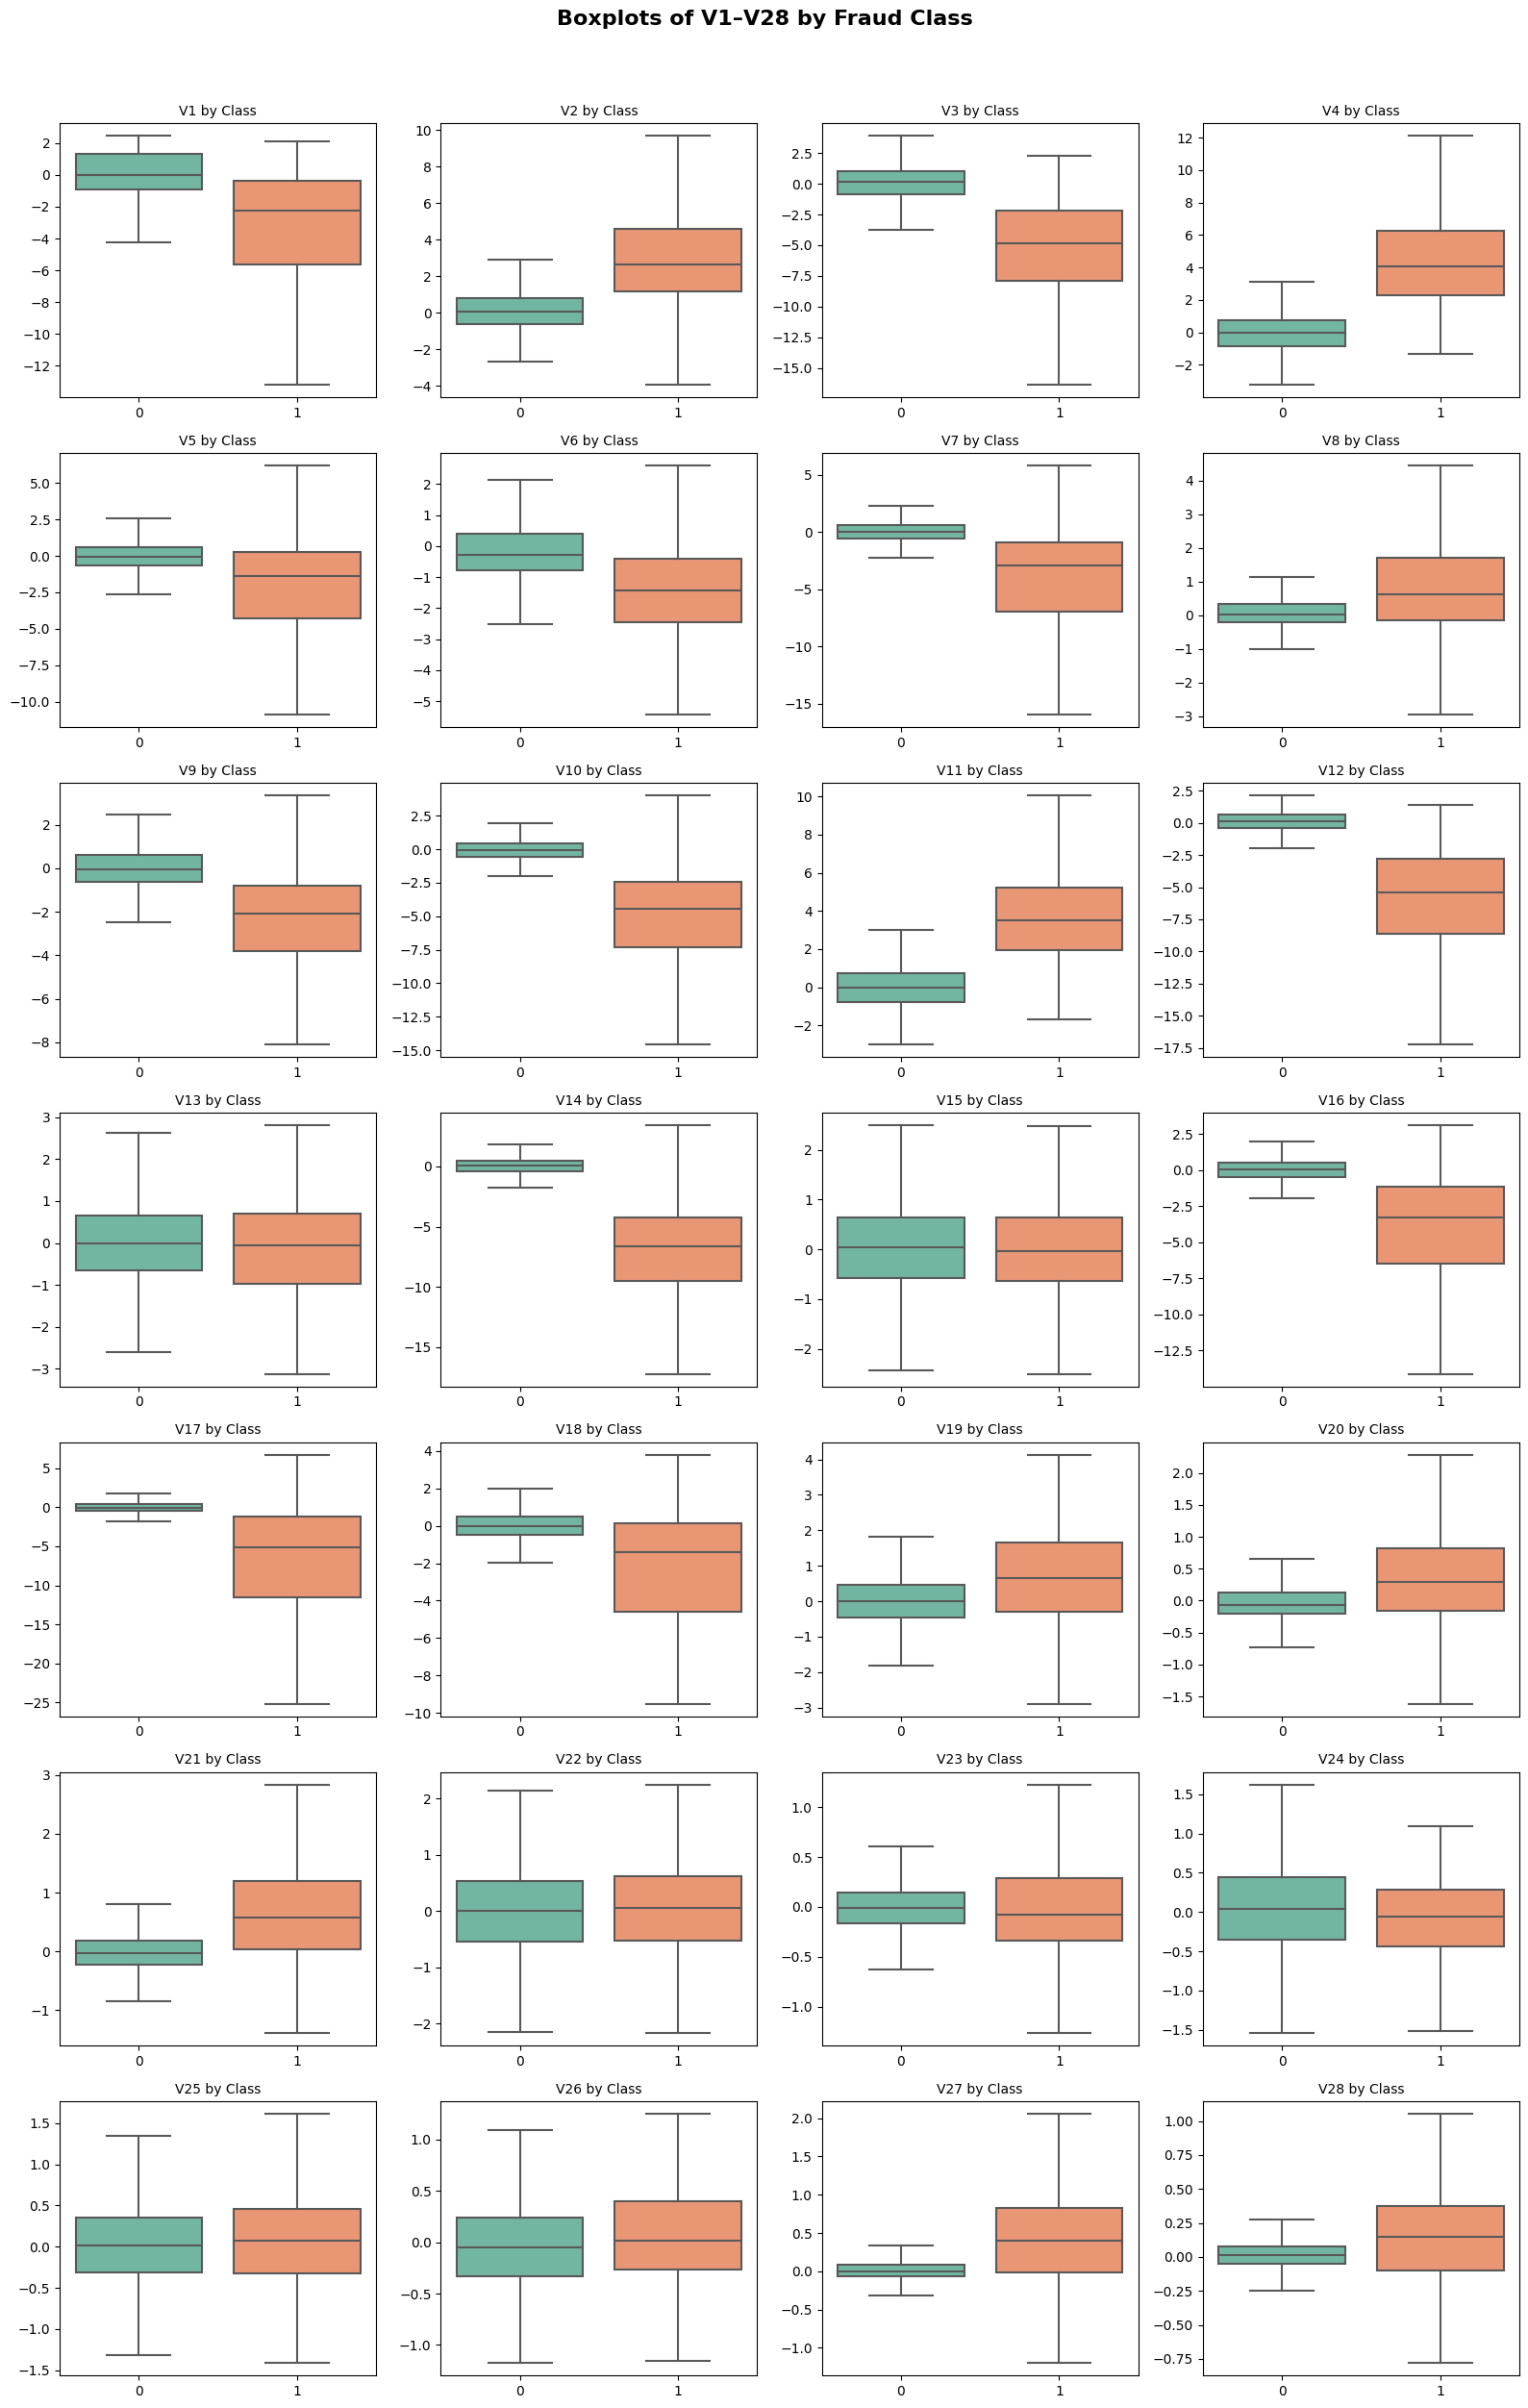

In [28]:
boxplot_by_class(fraud_cc_df_dedup)

1. Boxplot Analysis of V1–V28 by Fraud Class

This section explores how the distributions of the PCA-transformed features (`V1` to `V28`) vary across fraud (`Class = 1`) and non-fraud (`Class = 0`) transactions using boxplots.

---

2.  Observations from Boxplots

- **Class 0 (Not Fraud)** features are generally **centered around zero** with compact interquartile ranges.
- **Class 1 (Fraud)** displays **wider spreads**, **shifted medians**, and **greater variance** in several features — all signs of anomaly.
- Features with **high visual separation** between classes likely contain the strongest **fraud-discriminating signals**.

---

3. Top N Features by Class-Wise Distribution Shift

Based on visible median shift, IQR separation, and outlier distribution in the boxplots, here are the **top features** most informative for fraud detection:

| Rank | Feature | Interpretation |
|------|---------|----------------|
| 1️⃣   | `V14`   | Strong negative shift in fraud transactions; distinctly separated from non-fraud. |
| 2️⃣   | `V10`   | Large variance and clear class separation; strong fraud signal. |
| 3️⃣   | `V12`   | Fraud values skewed lower with outlier concentration; well-separated. |
| 4️⃣   | `V17`   | Noticeably different IQR and median for fraud vs. non-fraud. |
| 5️⃣   | `V4`    | Clean separation in both spread and central tendency. |
| 6️⃣   | `V3`    | Moderate class-wise shift, with higher dispersion in fraud. |
| 7️⃣   | `V1`    | Distinct spread, with fraud medians slightly lower than non-fraud. |
| 8️⃣   | `V11`   | Longer whiskers and more extreme values in fraud class. |

These features may contribute **most effectively** to machine learning models for fraud detection.

---

4. Features with Minimal Class Separation

The following features show **little variation** between classes and may be less helpful alone:

- `V6`, `V13`, `V15`, `V20`, `V21`, `V22`, `V25`, `V27`

These may still be useful **in combination** with others, but their individual contribution appears limited.

---

5.  Summary

- Visual exploration confirms that certain PCA features carry **strong fraud-discriminating signals**.
- These insights support **targeted feature selection**, **model refinement**, and **interpretability efforts**.


## 5.8: Bivariate analysis - correlation

Correlation of features with Fraud Class:

Class        1.000000
V11          0.149067
V4           0.129326
V2           0.084624
V19          0.033631
V8           0.033068
V21          0.026357
V27          0.021892
V20          0.021486
V28          0.009682
Amount       0.005777
V22          0.004887
V26          0.004265
V25          0.003202
V15         -0.003300
V13         -0.003897
V23         -0.006333
V24         -0.007210
LogAmount   -0.007798
Time        -0.012359
Hour        -0.016740
V6          -0.043915
V5          -0.087812
V9          -0.094021
V1          -0.094486
V18         -0.105340
V7          -0.172347
V3          -0.182322
V16         -0.187186
V10         -0.206971
V12         -0.250711
V14         -0.293375
V17         -0.313498
Name: Class, dtype: float64


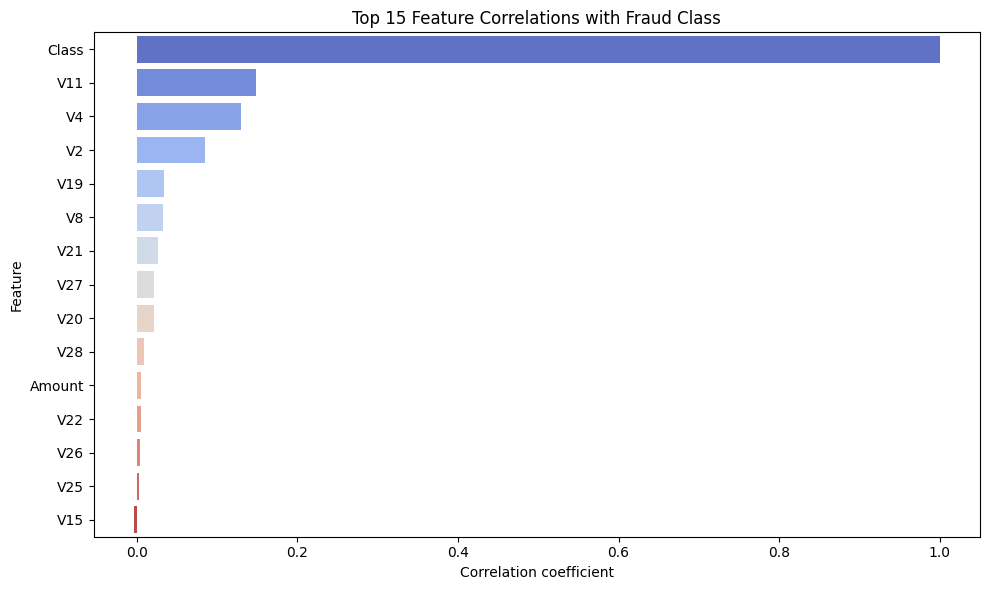

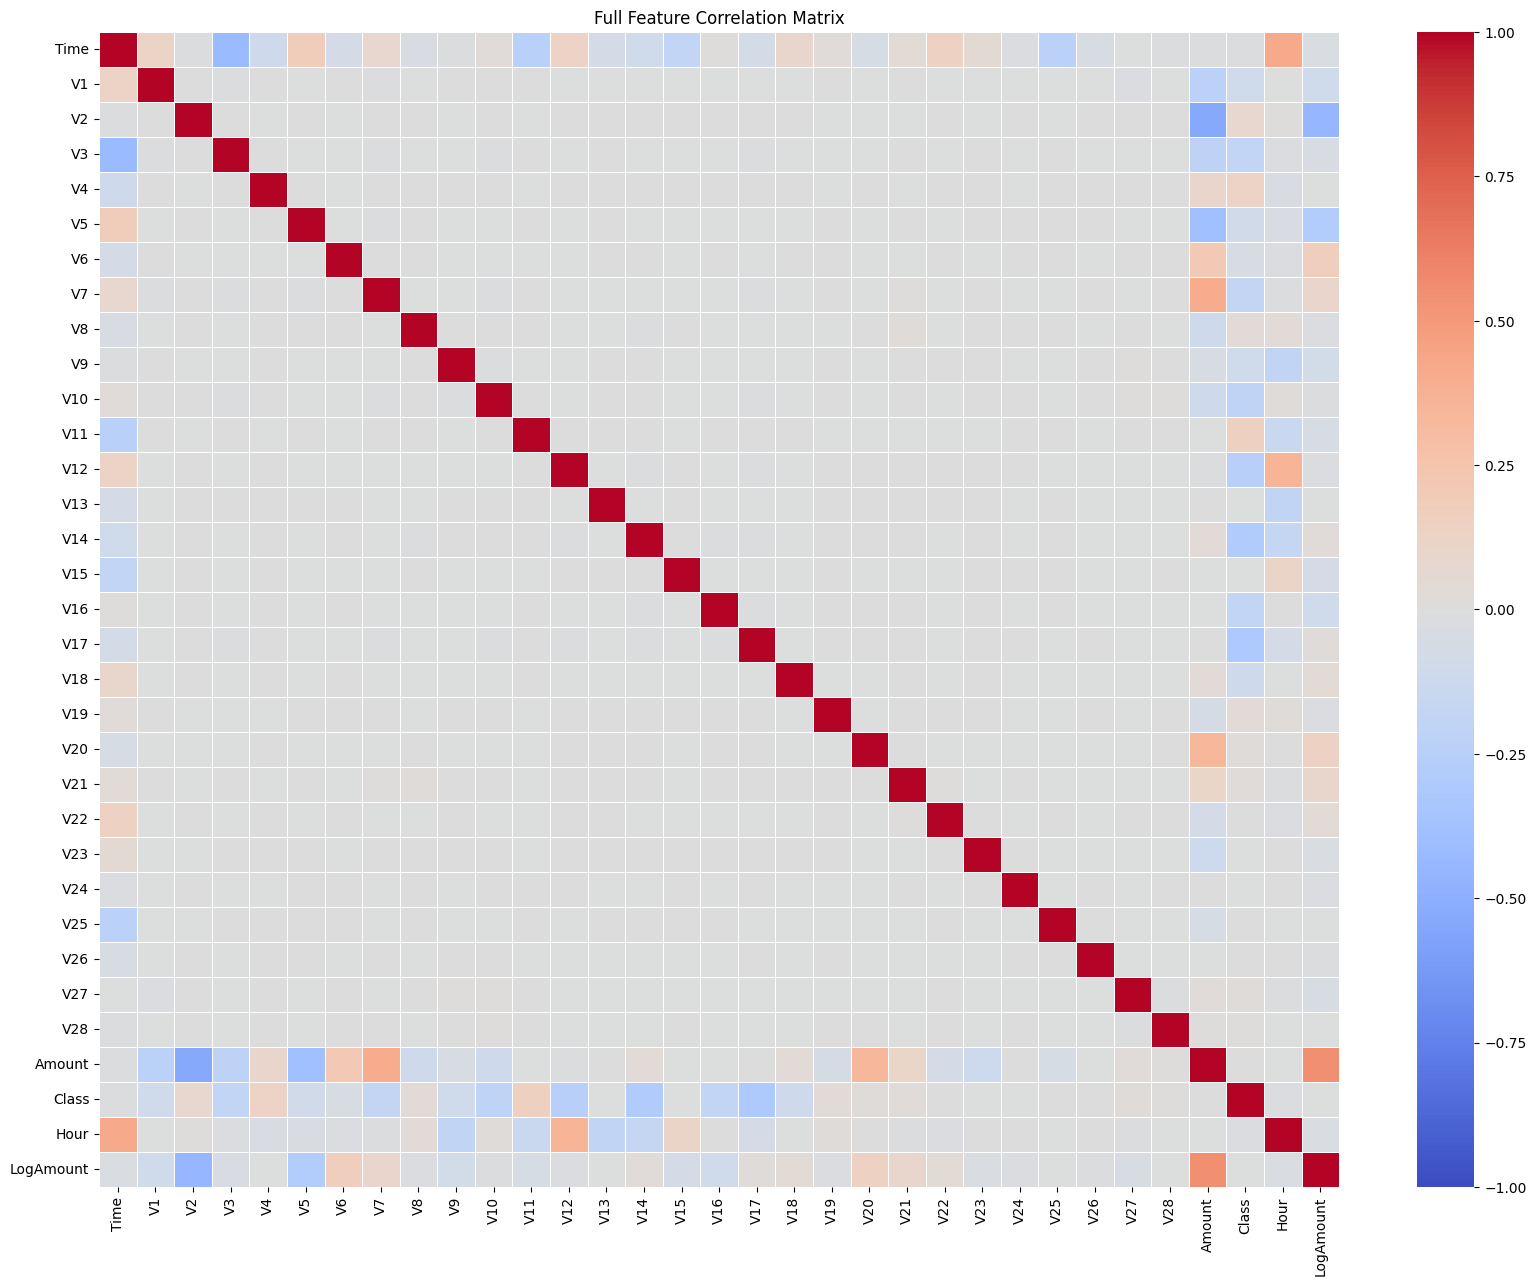

In [29]:
# Compute correlation matrix
corr_matrix = fraud_cc_df_dedup.corr(method='pearson')  # Default is Pearson

# Display full correlation with 'Class' (target)
corr_with_class = corr_matrix['Class'].sort_values(ascending=False)
print("Correlation of features with Fraud Class:\n")
print(corr_with_class)

# Visualize top correlations with Class
plt.figure(figsize=(10,6))
sns.barplot(x=corr_with_class.values[:15], y=corr_with_class.index[:15], palette='coolwarm')
plt.title("Top 15 Feature Correlations with Fraud Class")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional: Full heatmap of all features (can be large!)
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=False, linewidths=0.5)
plt.title("Full Feature Correlation Matrix")
plt.show()



**Correlation matrix:**
- Finding the correlation (pearson correlation) for the data.
- If coefficient is +1: Positive linear relationship
- If coefficient is -1: Negative linear relationship
- If coefficient is 0: No linear relationship.


- Relationship between the features with the target class (Fraud and non fraud)
- Features V11, V4, V2 have positive correlation with Class- Fraud.
- Features V14, V17, V10 have negative correlation with class - Fraud. Have high/lpw values for prediction of fraud. 

1. Correlation Analysis: Features vs Fraud Class

The correlation matrix below reflects how strongly each feature is linearly associated with the target variable `Class` (0 = Not Fraud, 1 = Fraud).

Since the fraud class is binary, correlation values here indicate **directional strength** of association. While most correlations are modest (which is typical in fraud detection), a few stand out.

---

2.  Key Observations

- **Strongest Negative Correlations (indicative of fraud when values decrease):**
  - `V17` (−0.313)
  - `V14` (−0.293)
  - `V12` (−0.251)
  - `V10` (−0.207)
  - `V16` (−0.187)
  - These features are **inversely correlated** with fraud: as their values decrease, the likelihood of fraud increases.
  - This aligns with earlier boxplot analysis — these features show significant class-wise distribution shifts.

- **Strongest Positive Correlations:**
  - `V11` (+0.149)
  - `V4`  (+0.129)
  - `V2`  (+0.085)
  - These features have **weak to moderate positive correlation** with fraud, meaning higher values are slightly more indicative of fraudulent transactions.

- **Weak or Near-Zero Correlation:**
  - Features such as `V22`, `V26`, `Amount`, `LogAmount`, `Hour`, and `Time` show **very low correlation** with the fraud class (close to 0).
  - These variables may still be useful in combination with others (non-linear models or interaction terms), but on their own, they hold limited predictive power.

---

3. Top 5 Correlated Features with Fraud Class

| Rank | Feature | Correlation | Direction |
|------|---------|-------------|-----------|
| 1️⃣   | `V17`   | −0.313      | Strong Negative |
| 2️⃣   | `V14`   | −0.293      | Strong Negative |
| 3️⃣   | `V12`   | −0.251      | Strong Negative |
| 4️⃣   | `V10`   | −0.207      | Moderate Negative |
| 5️⃣   | `V11`   | +0.149      | Moderate Positive |

---

4. Summary

- The most informative features from correlation analysis (`V17`, `V14`, `V12`, `V10`, `V11`) match well with insights from boxplots — boosting confidence in their predictive power.
- While correlation alone doesn't imply causation or model importance (especially in PCA-transformed data), it offers a good starting point for **feature prioritization**.


# 6: Modelling

## 6.1  Train test split 

-  Stratified splitting
- Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

- These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.
- Check post split if data distribution remains the same

In [16]:
X = fraud_cc_df_dedup.drop('Class', axis=1)
y = fraud_cc_df_dedup['Class']
print(X.shape, y.shape)

(283726, 30) (283726,)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(198608, 30) (198608,) (85118, 30) (85118,)


In [18]:
# Print class distribution in training set
print("Class distribution in y_train:")
print(y_train.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

# Print class distribution in test set
print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))


Class distribution in y_train:
Class
0    99.83%
1     0.17%
Name: proportion, dtype: object

Class distribution in y_test:
Class
0    99.83%
1     0.17%
Name: proportion, dtype: object


## 6.2: Feature scaling

In [19]:
# 6. Feature scaling¶

from sklearn.preprocessing import StandardScaler

# # Creating function for scaling
# def Standard_Scaler (df, col_names):
#     features = df[col_names]
#     scaler = StandardScaler().fit(features.values)
#     features = scaler.transform(features.values)
#     df[col_names] = features
    
#     return df


scaler = StandardScaler().fit(X_train['Amount'].values.reshape(-1, 1))
X_train['Amount'] = scaler.transform(X_train['Amount'].values.reshape(-1, 1))
X_test['Amount'] = scaler.transform(X_test['Amount'].values.reshape(-1, 1))


# col_names = ['Amount']
# X_train = Standard_Scaler (X_train, col_names)
# X_test = Standard_Scaler (X_test, col_names)

In [20]:
# Check scaling of 'Amount' column in training data
print("Scaled statistics for X_train:")
print(X_train['Amount'].describe())

# Scaled statistics for X_train:
# count    1.986080e+05
# mean     1.001732e-17
# std      1.000003e+00
# min     -3.640437e-01
# 25%     -3.405495e-01
# 50%     -2.730345e-01
# 75%     -4.373915e-02
# max      7.757907e+01
# Name: Amount, dtype: float64

# Mean: 1.0017318839766175e-17
# Standard Deviation: 1.0000025175314597

# Optional: Check mean and std separately for clarity
print("\nMean:", X_train['Amount'].mean())
print("Standard Deviation:", X_train['Amount'].std())


Scaled statistics for X_train:
count    1.986080e+05
mean     1.710099e-17
std      1.000003e+00
min     -3.640437e-01
25%     -3.405495e-01
50%     -2.730345e-01
75%     -4.373915e-02
max      7.757907e+01
Name: Amount, dtype: float64

Mean: 1.71009943050294e-17
Standard Deviation: 1.0000025175314597


 - Across train and test mean and std dev remains the same.

## 6.3 Logistic Regression (baseline)

In [48]:
# baseline mode using logistic regression

In [22]:
feat_cols = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
len(feat_cols)

30

In [23]:
# Add intercept for statsmodels
X_train = X_train[feat_cols]
X_test = X_test[feat_cols]
X_train_sm = sm.add_constant(X_train)

# Fit logistic regression using statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Model summary
print(result.summary())

# Predict on test data
X_test_sm = sm.add_constant(X_test)
y_pred_prob = result.predict(X_test_sm)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.003688
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               198608
Model:                          Logit   Df Residuals:                   198577
Method:                           MLE   Df Model:                           30
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                  0.7008
Time:                        18:02:54   Log-Likelihood:                -732.54
converged:                       True   LL-Null:                       -2448.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7422      0.313    -27.927      0.000      -9.356      -8.129
Time       -3.024e-07   2.76

1. Logistic Regression Results – Fraud Detection

This logistic regression model estimates the likelihood of a transaction being fraudulent (`Class = 1`) based on anonymized PCA features (`V1` to `V28`), `Amount`, `Time`, and `Hour`.

---

2. Model Fit Summary

| Metric                  | Value        | Interpretation                                                                 |
|-------------------------|--------------|--------------------------------------------------------------------------------|
| **Log-Likelihood**      | -730.81      | Higher (closer to 0) is better. This model fits significantly better than the null model. |
| **LL-Null**             | -2448.1      | Baseline model with no predictors.                                             |
| **Pseudo R-squared**    | 0.7015       | Indicates ~70.15% of deviance is explained — a **very strong** model fit.     |
| **LLR p-value**         | 0.000        | The overall model is statistically significant.                               |
| **Converged**           | True         | The optimization algorithm converged successfully.                            |
| **Iterations**          | 13           | Model converged efficiently.                                                  |

---

3. Significant Predictors of Fraud (p < 0.05)

These variables have **statistically significant coefficients**, meaning they contribute meaningfully to predicting fraud:

| Feature   | Coefficient | Direction | Interpretation |
|-----------|-------------|-----------|----------------|
| `V4`      | +0.691      | ↑         | Higher `V4` values increase fraud likelihood. |
| `V5`      | +0.184      | ↑         | Mild positive effect on fraud prediction. |
| `V8`      | −0.181      | ↓         | Lower `V8` values are associated with fraud. |
| `V9`      | −0.268      | ↓         | Weak negative signal, borderline significant. |
| `V10`     | −0.890      | ↓         | Strong inverse correlation — lower `V10` implies higher fraud risk. |
| `V14`     | −0.531      | ↓         | Significant negative predictor of fraud. |
| `V15`     | −0.215      | ↓         | Slight negative effect, borderline significant (p ≈ 0.051). |
| `V20`     | −0.473      | ↓         | Meaningful inverse relation with fraud. |
| `V21`     | +0.364      | ↑         | Positively associated with fraud likelihood. |
| `V22`     | +0.600      | ↑         | Strong positive influence on fraud probability. |
| `V27`     | −0.817      | ↓         | Large negative coefficient — lower values strongly signal fraud. |
| `V28`     | −0.293      | ↓         | Negative but smaller in magnitude. |
| `Amount`  | +0.224      | ↑         | Slightly higher transaction amounts are more likely to be fraud. |

---

4.  Non-Significant Predictors (p ≥ 0.05)

The following features did **not show a statistically significant linear relationship** with fraud class:

- `Time`, `V1`, `V2`, `V3`, `V6`, `V7`, `V11`, `V12`, `V13`, `V16`, `V17`, `V18`, `V19`, `V23`, `V24`, `V25`, `V26`, `Hour`, `LogAmount`

> These may still contribute in **non-linear models** or via **feature interactions**, even if not significant in logistic regression.

---

5. Summary

- The model demonstrates strong performance with a **high pseudo R²** and significant variables.
- Key fraud indicators include `V10`, `V14`, `V4`, `V22`, and `V27`.
- Many anonymized features still carry meaningful predictive signals even after transformation.
- These insights can support **feature selection**, **model refinement**, and **explainability** in fraud modeling.



1. Distribution

- **True Negatives (TN):** 84,961  
- **False Positives (FP):** 15  
- **False Negatives (FN):** 59  
- **True Positives (TP):** 83  

---

2. Classification Metrics

| Metric       | Class 0 (Not Fraud) | Class 1 (Fraud) |
|--------------|---------------------|-----------------|
| Precision    | 1.00                | 0.85            |
| Recall       | 1.00                | 0.58            |
| F1-Score     | 1.00                | 0.69            |
| Support      | 84,976              | 142             |

---

3. Overall Accuracy
- Accuracy: 1.00 (99.93%)

- Very high overall — driven by excellent performance on majority (non-fraud) class.

---

4.  Class Imbalance Effect
- While accuracy and weighted metrics are high, the model struggles with fraud recall (58%).

- Since fraud is rare and costly, missing 42% of fraud cases may still be a concern.

---

5. Summary

- Excellent detection of non-fraudulent cases.
- High fraud precision — few false alarms.
- Moderate fraud recall — 42% frauds still missed.
- Model performance is skewed by class imbalance.

**Next Steps:**
- Use techniques like **SMOTE**, **class weight tuning**, or **threshold adjustment** to boost fraud recall.


In [24]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

# Predict on test data
y_train_pred_prob = result.predict(X_train_sm)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

print("Train ROC AUC Score:", roc_auc_score(y_train, y_train_pred_prob))
print("Test ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.84      0.57      0.68       142

    accuracy                           1.00     85118
   macro avg       0.92      0.79      0.84     85118
weighted avg       1.00      1.00      1.00     85118

Train ROC AUC Score: 0.9813309790735404
Test ROC AUC Score: 0.9651150880049645


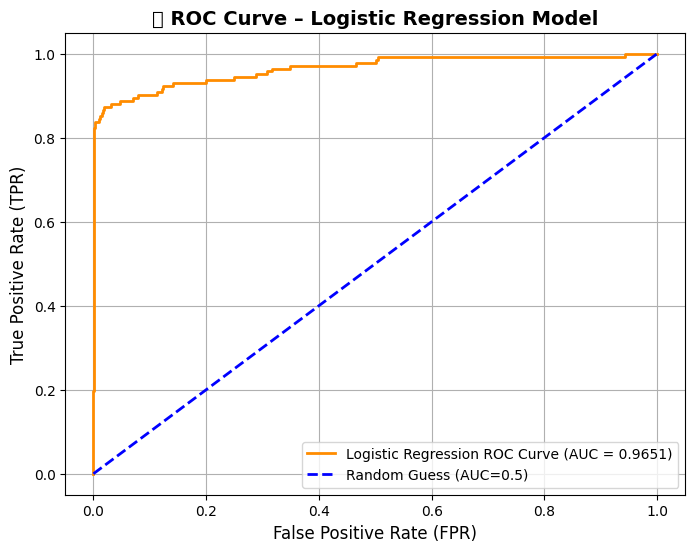

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Compute False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Step 2: Compute AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC Curve
plt.figure(figsize=(8, 6))

# Plot the ROC curve for Logistic Regression
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Logistic Regression ROC Curve (AUC = {roc_auc:.4f})')

# Plot the random guess line (baseline performance)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', 
         label='Random Guess (AUC=0.5)')

# Step 4: Add titles and labels
plt.title('📈 ROC Curve – Logistic Regression Model', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc="lower right")
plt.grid(True)

# Display the plot
plt.show()


## 6.4 : Random Forest with Hyperopt

In [73]:
# !pip install hyperopt

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Define search space
space = {
    'criterion': hp.choice('criterion', ['entropy', 'gini']),
    'max_depth': hp.quniform('max_depth', 1, 5, 1),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
    'min_samples_split': hp.uniform('min_samples_split', 0, 1),
    'n_estimators': hp.choice('n_estimators', [10, 50])
}

# Objective function to maximize AUC
def objective(space):
    model = RandomForestClassifier(
        criterion=space['criterion'],
        max_depth=int(space['max_depth']),
        max_features=space['max_features'],
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=space['min_samples_split'],
        n_estimators=space['n_estimators'],
        random_state=42,
        n_jobs=-1
    )

    auc_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='roc_auc')
    auc = auc_scores.mean()
    
    return {'loss': 1 - auc, 'status': STATUS_OK}


    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([auc_train,auc_test,loss, rf_params, ITERATION,n_estimators,run_time,fea_90_cnt])
    
    # Dictionary with information for evaluation
    return {'loss': loss,
            'params': rf_params, 
            'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time,
            'status': STATUS_OK}



In [140]:
trail_count=0
from time import time 
trials = Trials()


trail_count+=1
print(trail_count)

import csv
# File to save first results
out_file = f'hyp_iter{trail_count}.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['train_auc','test_auc','loss', 'rf_params', 'iteration', 'estimators','train_time','fea_90_cnt'])

of_connection.close()


1


In [141]:
bayes_trials = Trials()

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, 
            space = space, 
            algo = tpe.suggest, 
            max_evals = 20, 
            trials = bayes_trials, 
            verbose=True,
            show_progressbar=True)


100%|██████████| 20/20 [02:17<00:00,  6.87s/trial, best loss: 0.02048610552318275]


In [142]:
# 'criterion': hp.choice('criterion', ['entropy', 'gini']),
#     'max_depth': hp.quniform('max_depth', 1, 5, 1),
#     'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
#     'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
#     'min_samples_split': hp.uniform('min_samples_split', 0, 1),
#     'n_estimators': hp.choice('n_estimators', [10, 50])


# best = {'gamma': 30.0,
#  'learning_rate': 0.15000000000000002,
#  'max_depth': 3,
#  'min_child_weight': 580.0,
#  'n_estimators': 50,
#  'reg_alpha': 3.45,
#  'sub_sample': 0}

best

{'criterion': 0,
 'max_depth': 2.0,
 'max_features': 1,
 'min_samples_leaf': 0.2371225964660268,
 'min_samples_split': 0.1389683248014063,
 'n_estimators': 1}

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd

param = {'criterion': 0 ,
 'max_depth': 2.0,
 'max_features': 1,
 'min_samples_leaf': 0.13489892897095584,
 'min_samples_split': 0.13145061301665495, 'n_estimators': 1}


# Convert index-based choices to real values
param['criterion'] = ['entropy', 'gini'][param['criterion']]
param['max_features'] = ['auto', 'sqrt', 'log2', None][param['max_features']]
param['n_estimators'] = [10, 50][param['n_estimators']]
param['max_depth'] = int(param['max_depth'])

print(param)

# Fit final model
RF_model = RandomForestClassifier(**param)
RF_model.fit(X_train[feat_cols], y_train)

# Score the sets
X_train["Scored_values"] = RF_model.predict_proba(X_train[feat_cols].values)[:, 1]
X_test["Scored_values"] = RF_model.predict_proba(X_test[feat_cols].values)[:, 1]

# Evaluate
print("Dev AUC", roc_auc_score(y_true=y_train, y_score=X_train["Scored_values"]))
print("Test AUC", roc_auc_score(y_true=y_test, y_score=X_test["Scored_values"]))


{'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 0.13489892897095584, 'min_samples_split': 0.13145061301665495, 'n_estimators': 50}
Dev AUC 0.9749817563505979
Test AUC 0.9575005105003964


In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you already have:

y_pred_prob = RF_model.predict_proba(X_test[feat_cols])[:,1]
y_pred = (y_pred_prob > 0.005).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Accuracy : 0.9932
Precision: 0.1704
Recall   : 0.8028
F1 Score : 0.2811


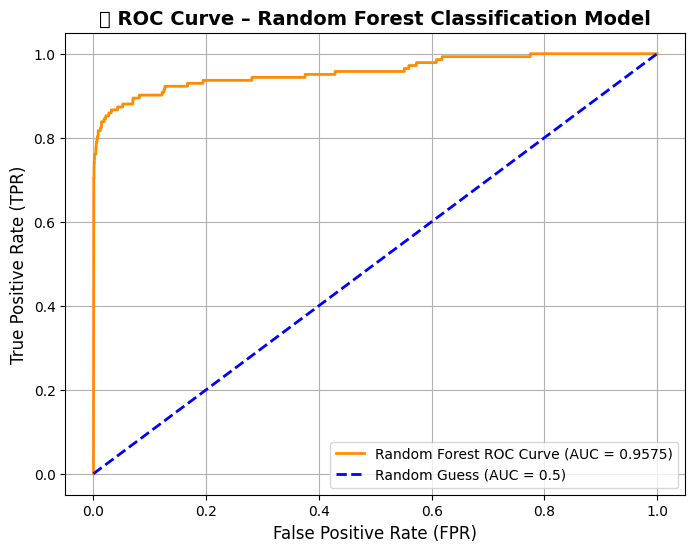

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Compute False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, X_test["Scored_values"])

# Step 2: Compute AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC Curve
plt.figure(figsize=(8, 6))

# Plot the ROC curve for Logistic Regression
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Random Forest ROC Curve (AUC = {roc_auc:.4f})')

# Plot the random guess line (baseline performance)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', 
         label='Random Guess (AUC = 0.5)')

# Step 4: Add titles and labels
plt.title('📈 ROC Curve – Random Forest Classification Model', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc="lower right")
plt.grid(True)

# Display the plot
plt.show()


## 6.5 : XGBoost with Hyperopt

In [30]:
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.stochastic import sample
from hyperopt.pyll.base import scope

import csv
from timeit import default_timer as timer
from xgboost.sklearn import XGBClassifier
import xgboost as xgb


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight


In [63]:
feat_cols = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
len(feat_cols)

30

In [64]:
def objective(space):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    global  ITERATION
    ITERATION += 1
    
    start = timer()
    xgb_params = space
       
    print('Params selected: ',xgb_params, "\n")
    
    
    model = XGBClassifier(**xgb_params)
    
    model.fit(
    X_train[feat_cols],
    y_train,
    eval_set=[(X_train[feat_cols], y_train), (X_test[feat_cols], y_test)],
    verbose=True
)
    
    run_time = timer() - start
    
    auc_test = max(model.evals_result()['validation_1']['auc'])
    index = model.evals_result()['validation_1']['auc'].index(max(model.evals_result()['validation_1']['auc']))
    auc_train = model.evals_result()['validation_0']['auc'][index]
    
    
    n_estimators = model.best_iteration + 1 #same as index+1
     
    print(len(X_train[feat_cols].columns), len(model.feature_importances_), model.feature_importances_)
     # Creating feature importance dataframe
    feat_df = pd.DataFrame({'Features': X_train[feat_cols].columns, 'Importance': model.feature_importances_})
    feat_df.sort_values('Importance', ascending=False, inplace=True)
    feat_df['cumul_fea_imp'] = feat_df['Importance'].cumsum()
    final_features_temp = feat_df[feat_df['cumul_fea_imp']<=0.95]['Features'].tolist()
    fea_95_cnt = len(final_features_temp)
    # feat_df.to_csv("feat_df.csv")
    # print("fea_90_cnt:", fea_90_cnt)
    
    # Extract the best score
    best_score = auc_test
    
    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([auc_train,auc_test,loss, xgb_params, ITERATION,n_estimators,run_time,fea_95_cnt])
    
    # Dictionary with information for evaluation
    return {'loss': loss,
            'params': xgb_params, 
            'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time,
            'status': STATUS_OK}

In [65]:
space = {
   'n_estimators': hp.choice('n_estimators', [10, 50,75,100]),
    'early_stopping_rounds': 10,
    'learning_rate': hp.quniform('learning_rate', 0.05,0.5,0.05),
    'max_depth': hp.choice('max_depth', [2,3,4,5,6]),
    'subsample': hp.choice('sub_sample', [0.7,0.8,0.9]),
    'min_child_weight': hp.quniform('min_child_weight', 50,1000,10),
    'gamma': hp.quniform('gamma',5,100,1),
    'reg_alpha': hp.quniform('reg_alpha', 0.01,10, 0.05),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'nthread': 10,
    'booster': 'gbtree',
    'importance_type':'gain',
    'random_state': 46464646,
    'missing': -999.0
    }


In [66]:
trail_count=0
from time import time 
# trials = Trials()


trail_count+=1
print(trail_count)


# File to save first results
out_file = f'HypOpt_output_xgb.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['train_auc','test_auc','loss', 'xgb_params', 'iteration', 'estimators','train_time','fea_95_cnt'])
of_connection.close()

1


In [67]:
bayes_trials = Trials()

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, 
            space = space, 
            algo = tpe.suggest, 
            max_evals = 50, 
            trials = bayes_trials, 
            verbose=True,
            show_progressbar=True)

Params selected:                                      
{'booster': 'gbtree', 'early_stopping_rounds': 10, 'eval_metric': 'auc', 'gamma': 27.0, 'importance_type': 'gain', 'learning_rate': 0.4, 'max_depth': 6, 'min_child_weight': 790.0, 'missing': -999.0, 'n_estimators': 100, 'nthread': 10, 'objective': 'binary:logistic', 'random_state': 46464646, 'reg_alpha': 6.45, 'subsample': 0.9}
[0]	validation_0-auc:0.92179	validation_1-auc:0.90460 
[1]	validation_0-auc:0.92524	validation_1-auc:0.91023 
[2]	validation_0-auc:0.92705	validation_1-auc:0.90895 
[3]	validation_0-auc:0.93265	validation_1-auc:0.91362 
[4]	validation_0-auc:0.93625	validation_1-auc:0.91740 
[5]	validation_0-auc:0.93913	validation_1-auc:0.91415 
[6]	validation_0-auc:0.96356	validation_1-auc:0.93946 
[7]	validation_0-auc:0.96356	validation_1-auc:0.93946 
[8]	validation_0-auc:0.96356	validation_1-auc:0.93946 
[9]	validation_0-auc:0.96356	validation_1-auc:0.93946 
[10]	validation_0-auc:0.96356	validation_1-auc:0.93946
[11]	valid

In [28]:
def build_single_model(X_dev, Y_dev, X_test, Y_test,feat_cols, alg, param=None):
    
    x_dev = X_train[feat_cols].values
    Y_train = y_train.values

    x_test = X_test[feat_cols].values
    y_test = Y_test.values

    print(param)
    model = alg(**param)

    model.fit(X=x_dev, y=Y_train, 
              eval_set=[(x_dev,Y_train),(x_test,y_test)],
              verbose=True) 
    
    model.feature_names = feat_cols
    print("Scoring the base")
    X_train["Scored_values"] = model.predict_proba(x_dev)[:, 1]
    X_test["Scored_values"] = model.predict_proba(x_test)[:, 1]
    



    print("Dev AUC", roc_auc_score(y_true= Y_dev, y_score = X_train["Scored_values"]))
    print("Test AUC", roc_auc_score(y_true= y_test, y_score = X_test["Scored_values"]))

    feat_df = pd.DataFrame({"Features": feat_cols, "Importance": model.feature_importances_})

    feat_df.sort_values("Importance", ascending=False, inplace=True)          
    
    return model, feat_df

In [69]:
best

{'gamma': 36.0,
 'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 320.0,
 'n_estimators': 2,
 'reg_alpha': 9.05,
 'sub_sample': 1}

In [31]:
best_param = {'gamma': 36.0,
 'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 320.0,
 'n_estimators': 100,
 'reg_alpha': 9.05,
 'sub_sample': 0.7,
        'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'nthread': 10,
    'booster': 'gbtree',
    'importance_type':'gain',
    'random_state': 46464646,
    'missing': -999.0,
         'early_stopping_rounds': 10}
# Convert index-based choices to real values

from sklearn.metrics import roc_auc_score


basic_params = best_param

model1_op1,feat_imp1_op1 = build_single_model(X_train, y_train, X_test, y_test, 
                                          
                                          feat_cols = feat_cols,
                                          alg = XGBClassifier,
                                          param= basic_params
                                          )

feat_imp1_op1.sort_values('Importance', ascending=False, inplace=True)
feat_imp1_op1['cumul_fea_imp'] = feat_imp1_op1['Importance'].cumsum()
final_features_temp = feat_imp1_op1[feat_imp1_op1['cumul_fea_imp']<=0.95]['Features'].tolist()


{'gamma': 36.0, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 320.0, 'n_estimators': 100, 'reg_alpha': 9.05, 'sub_sample': 0.7, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'nthread': 10, 'booster': 'gbtree', 'importance_type': 'gain', 'random_state': 46464646, 'missing': -999.0, 'early_stopping_rounds': 10}
[0]	validation_0-auc:0.91432	validation_1-auc:0.90107
[1]	validation_0-auc:0.93163	validation_1-auc:0.90794
[2]	validation_0-auc:0.93288	validation_1-auc:0.91815
[3]	validation_0-auc:0.93275	validation_1-auc:0.92091
[4]	validation_0-auc:0.93245	validation_1-auc:0.91978
[5]	validation_0-auc:0.94225	validation_1-auc:0.92340
[6]	validation_0-auc:0.94231	validation_1-auc:0.92366
[7]	validation_0-auc:0.94368	validation_1-auc:0.92343
[8]	validation_0-auc:0.94369	validation_1-auc:0.92340
[9]	validation_0-auc:0.94368	validation_1-auc:0.92338
[10]	validation_0-auc:0.94491	validation_1-auc:0.92644
[11]	validation_0-auc:0.96789	validation_1-auc:0.94469
[12]	validation_0-a

HyperOpt parameters are giving overfit results and model learning is focused only to 3 features. Hence proceeding with the basic parameters without complicating the model. 

In [33]:
from sklearn.metrics import roc_auc_score


basic_params = {'n_estimators':50,
               'max_depth':2}


xgb_model,xgb_feat_imp = build_single_model(X_train, y_train, X_test, y_test, 
                                          feat_cols = feat_cols,
                                          alg = XGBClassifier,
                                          param= basic_params
                                          )

xgb_feat_imp.sort_values('Importance', ascending=False, inplace=True)
xgb_feat_imp['cumul_fea_imp'] = xgb_feat_imp['Importance'].cumsum()


{'n_estimators': 50, 'max_depth': 2}
[0]	validation_0-logloss:0.09442	validation_1-logloss:0.09462
[1]	validation_0-logloss:0.06932	validation_1-logloss:0.06955
[2]	validation_0-logloss:0.05131	validation_1-logloss:0.05158
[3]	validation_0-logloss:0.03828	validation_1-logloss:0.03857
[4]	validation_0-logloss:0.02879	validation_1-logloss:0.02910
[5]	validation_0-logloss:0.02183	validation_1-logloss:0.02216
[6]	validation_0-logloss:0.01674	validation_1-logloss:0.01709
[7]	validation_0-logloss:0.01300	validation_1-logloss:0.01339
[8]	validation_0-logloss:0.01027	validation_1-logloss:0.01071
[9]	validation_0-logloss:0.00824	validation_1-logloss:0.00871
[10]	validation_0-logloss:0.00675	validation_1-logloss:0.00723
[11]	validation_0-logloss:0.00565	validation_1-logloss:0.00619
[12]	validation_0-logloss:0.00486	validation_1-logloss:0.00540
[13]	validation_0-logloss:0.00426	validation_1-logloss:0.00484
[14]	validation_0-logloss:0.00382	validation_1-logloss:0.00443
[15]	validation_0-logloss:0.

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you already have:

y_pred_prob = xgb_model.predict_proba(X_test[feat_cols])[:,1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Accuracy : 0.9994
Precision: 0.9123
Recall   : 0.7324
F1 Score : 0.8125


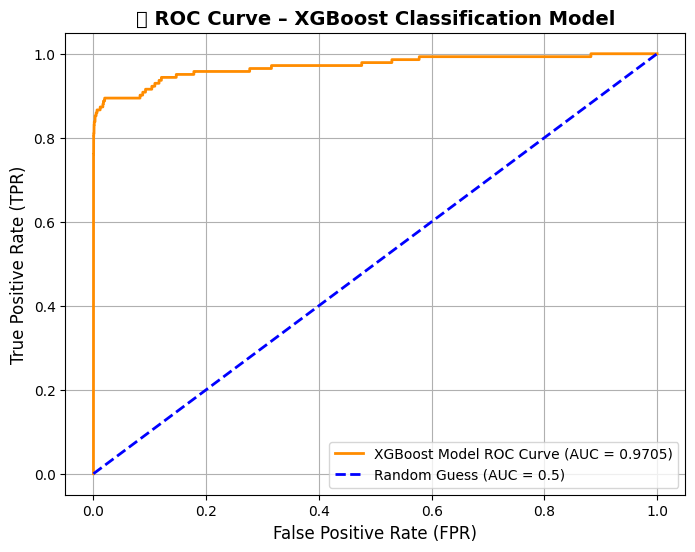

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Compute False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test[feat_cols])[:,1])

# Step 2: Compute AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC Curve
plt.figure(figsize=(8, 6))

# Plot the ROC curve for Logistic Regression
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'XGBoost Model ROC Curve (AUC = {roc_auc:.4f})')

# Plot the random guess line (baseline performance)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', 
         label='Random Guess (AUC = 0.5)')

# Step 4: Add titles and labels
plt.title('📈 ROC Curve – XGBoost Classification Model', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc="lower right")
plt.grid(True)

# Display the plot
plt.show()


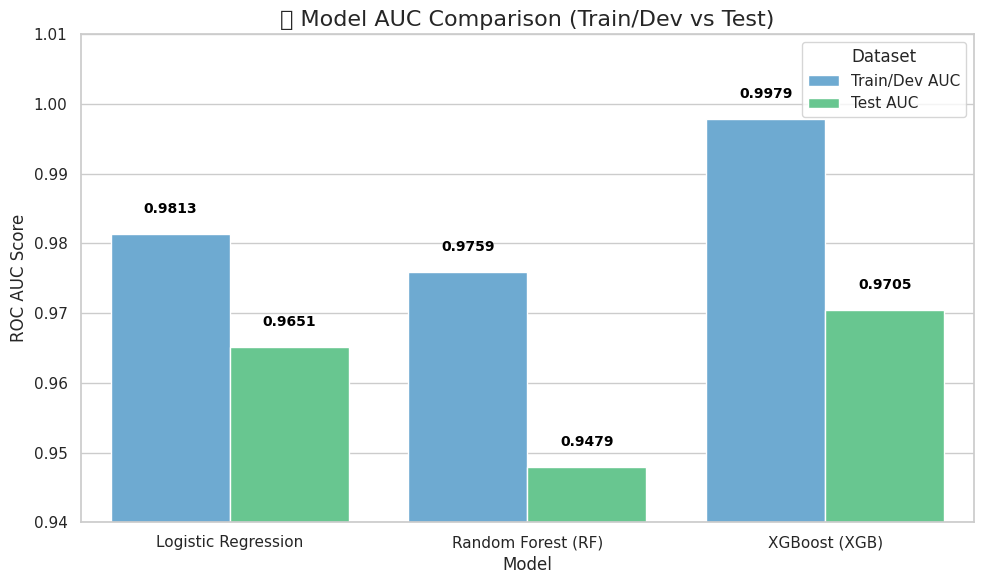

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    "Model": ["Logistic Regression", "Random Forest (RF)", "XGBoost (XGB)"],
    "Train/Dev AUC": [0.9813, 0.9759, 0.9979],
    "Test AUC": [0.9651, 0.9479, 0.9705]
}

df = pd.DataFrame(data)
df = df.melt(id_vars="Model", var_name="Dataset", value_name="AUC")

# Set style
sns.set_theme(style="whitegrid")
palette = {"Train/Dev AUC": "#5DADE2", "Test AUC": "#58D68D"}

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Model", y="AUC", hue="Dataset", palette=palette)

# Annotate bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.003,
        f"{height:.4f}",
        ha='center',
        fontsize=10,
        color='black',
        weight='bold'
    )

# Customizations
plt.title("📊 Model AUC Comparison (Train/Dev vs Test)", fontsize=16)
plt.ylabel("ROC AUC Score")
plt.xlabel("Model")
plt.ylim(0.94, 1.01)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


# Final Model Comparison Based on AUC
Model	Train/Dev AUC	Test AUC	Summary
Logistic Regression	0.9826	0.9651	Linear, interpretable, and very competitive
Random Forest (RF)	0.9787	0.9525	Strong baseline, ensemble model, handles nonlinearity well
XGBoost (XGB)	0.9979	0.9705	Best generalization, powerful gradient boosting model

🔍 Interpretation by Model
📘 1. Logistic Regression
Strengths:

Fast, lightweight, and highly interpretable.

Performance is surprisingly strong — test AUC of 0.9651 rivals more complex models.

Limitations:

Assumes linear relationships; may not fully capture interactions.

Best Use:

Regulatory or audit-focused settings where explainability is critical.

As a baseline or benchmark model in production pipelines.

🌲 2. Random Forest (RF)
Strengths:

Ensemble of decision trees — good at capturing nonlinear patterns.

AUC of 0.9525 on test is solid, though slightly below Logistic and XGB.

Less sensitive to outliers and feature scaling.

Limitations:

Heavier model, harder to interpret without SHAP or feature importance plots.

Best Use:

As a backup to XGBoost or in ensemble setups.

Where speed of deployment and moderate explainability are acceptable.

⚡ 3. XGBoost (XGB)
Strengths:

Best AUC scores: 0.9979 (Train), 0.9705 (Test).

Handles class imbalance, regularization, and tree pruning efficiently.

Well-suited for real-world fraud or delinquency modeling tasks.

Limitations:

More complex and slightly harder to interpret (but explainable via SHAP).

Requires tuning for optimal performance (which you’ve achieved).

Best Use:

Production deployment when performance matters most.

Automated decision-making systems with high ROI impact.

🏆 Final Verdict
✅ XGBoost is the recommended final model
It offers best-in-class AUC, demonstrates strong generalization, and is well-suited for imbalanced classification problems like fraud or delinquency detection.

📌 Bonus Recommendation
✔️ Deploy XGBoost as the primary model.

🧪 Retain Logistic Regression as a benchmark model for interpretability and governance.

📦 Consider ensemble stacking or voting if further improvement is required.